# Environment Setup

In [1]:
from datetime import date, datetime, time, timedelta
start_time = datetime.now()

!pip install geopy
!pip install beautifulsoup4
!pip install lxml
!pip install folium
!pip install requests
!pip install xlrd
!pip install numpy

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import folium
import requests
import json
from pandas.io.json import json_normalize
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import silhouette_score, silhouette_samples
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import math
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Download

#### COVID-19 Daily Cases from ECDC

In [3]:
# Download the latest available public data on COVID-19 from European Centre for Disease Prevention and Control site.
# Data Content: Geographic distribution of COVID-19 cases & deaths worldwide

warnings.filterwarnings('ignore')

json_data = requests.get('https://opendata.ecdc.europa.eu/covid19/casedistribution/json/').json()
records = json_data['records']
daily_covid_df = pd.json_normalize(records)
daily_covid_df.columns = pd.Series(daily_covid_df.columns).apply(lambda x: x.lower()).tolist()

for i in np.arange(1,6):
    daily_covid_df.iloc[:,i] = daily_covid_df.iloc[:,i].astype('int')
    
daily_covid_df.iloc[:,0] = pd.to_datetime(daily_covid_df.iloc[:,0], format='%d/%m/%Y')
daily_covid_df.drop(['geoid', 'continentexp', 'countryterritorycode', 'popdata2018'], axis=1, inplace=True)
daily_covid_df.columns = 'date_reported', 'day_reported', 'month_reported', 'year_reported', 'covid_cases', 'covid_deaths', 'country'

for i in np.arange(daily_covid_df.shape[0]):
    daily_covid_df.country[i] = daily_covid_df.country[i].replace('_', ' ')

daily_covid_df = daily_covid_df[daily_covid_df.covid_cases>=0]
    
daily_covid_df.head(1)

date_reported  day_reported  month_reported  year_reported  covid_cases  \
0    2020-05-25            25               5           2020          584   

   covid_deaths      country  
0             2  Afghanistan

#### Daily Government Responses from Oxford University

In [4]:
# Download 'OXFORD COVID-19 GOVERNMENT RESPONSE TRACKER' dataset from Oxford University site.
# Data Content: OxCGRT collects publicly available information on 13 indicators of government response (S1-S13). 
#               Nine of the indicators (S1-S7, S12 and S13) take policies such as school closures, travel bans, etc. are recorded on an ordinal scale; 
#               the remainder (S8-S11) are financial indicators such as fiscal or monetary measures. For a full description of the data and how it is collected, 
#               see the working paper.

gov_response_df = pd.read_csv('https://oxcgrtportal.azurewebsites.net/api/CSVDownload')
gov_response_df = gov_response_df.iloc[:,:-1]
gov_response_df.columns = pd.Series(gov_response_df.columns).apply(lambda x: x.lower()).tolist()
gov_response_df.drop(columns='countrycode', inplace=True)
gov_response_df.rename(columns={'countryname':'country'}, inplace=True)
gov_response_df.date = pd.to_datetime(gov_response_df.date, format='%Y%m%d')
countries = gov_response_df.country
gov_response_df = gov_response_df.groupby('country').ffill().fillna(0)
gov_response_df.insert(loc=0, column='country', value=countries)

drop_col = []
col = list(gov_response_df.columns)
for i in np.arange(len(col)):
    col[i] = col[i].replace(' ','_').lower()
    try:
        x = re.search('notes$', col[i])
        drop_col = drop_col + [x.string]
    except:
        pass
gov_response_df.columns = col
drop_col = drop_col + ['confirmedcases'] + ['confirmeddeaths'] + ['stringencyindexfordisplay'] + ['stringencylegacyindex'] + ['stringencylegacyindexfordisplay'] + ['governmentresponseindex'] + ['governmentresponseindexfordisplay'] + ['containmenthealthindex'] + ['containmenthealthindexfordisplay'] + ['economicsupportindex']
gov_response_df.drop(columns=drop_col, inplace=True)

gov_response_df.head(1)

country       date  c1_school_closing  c1_flag  c2_workplace_closing  \
0   Aruba 2020-01-01                0.0      0.0                   0.0   

   c2_flag  c3_cancel_public_events  c3_flag  c4_restrictions_on_gatherings  \
0      0.0                      0.0      0.0                            0.0   

   c4_flag  c5_close_public_transport  c5_flag  c6_stay_at_home_requirements  \
0      0.0                        0.0      0.0                           0.0   

   c6_flag  c7_restrictions_on_internal_movement  c7_flag  \
0      0.0                                   0.0      0.0   

   c8_international_travel_controls  e1_income_support  e1_flag  \
0                               0.0                0.0      0.0   

   e2_debt/contract_relief  e3_fiscal_measures  e4_international_support  \
0                      0.0                 0.0                       0.0   

   h1_public_information_campaigns  h1_flag  h2_testing_policy  \
0                              0.0      0.0                0.0   

   h3_contact_tracing  h4_emergency_investment_in_healthcare  \
0                 0.0                                    0.0   

   h5_investment_in_vaccines  m1_wildcard  stringencyindex  
0                        0.0          0.0              0.0

#### World Demographic Data from the United Nations

In [5]:
# Download 'Old-Age Dependency Ratio 1' data from United Nations site.
# Data Content: Old-Age Dependency Ratio (Age 65+ / Age 15-64) De facto population as of 1 July of the year indicated

old_dep_ratio_df = pd.read_excel(
    'https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/EXCEL_FILES/1_Population/WPP2019_POP_F13_A_OLD_AGE_DEPENDENCY_RATIO_1564.xlsx', 
    index_col=0, 
    sheet_name='ESTIMATES', 
    skiprows=range(16))
old_dep_ratio_df.columns = pd.Series(old_dep_ratio_df.columns).apply(lambda x: x.lower()).tolist()
old_dep_ratio_df = old_dep_ratio_df[old_dep_ratio_df.type=='Country/Area'].reset_index(drop=True)
old_dep_ratio_df = old_dep_ratio_df.iloc[:,[1,len(old_dep_ratio_df.columns)-1]]
old_dep_ratio_df.columns = 'country', 'old_dep_ratio_2020'
old_dep_ratio_df = old_dep_ratio_df.astype({'old_dep_ratio_2020':'float'})
old_dep_ratio_df.set_index('country', inplace=True)

old_dep_ratio_df.head(1)

old_dep_ratio_2020
country                    
Burundi            4.545029

#### Country Geographical Coordinates from WHO

In [6]:
# Download 'WHO COVID Cases Data' from Humanitarian Data Exchange site.
# Data Content: WHO covid-19 cases data with country centroid coordinates

country_coord_df = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/e/2PACX-1vTBI8MZx7aNt8EjYqkeojTopZKwSYGWCSKUzyS9xobrS5Tfr9SQZ_4hrp3dv6bRGkHk2dld0wRrJIeV/pub?gid=32379430&single=true&output=csv', 
    usecols=[1,5,6],
    keep_default_na=True)
country_coord_df.columns = pd.Series(country_coord_df.columns).apply(lambda x: x.lower()).tolist()
country_coord_df.rename(columns={'adm0_name': 'country', 'center_lon': 'longitude', 'center_lat': 'latitude'}, inplace=True)
country_coord_df = country_coord_df.groupby('country').mean().reset_index(drop=False)

filtered_index = []
for i in np.arange(country_coord_df.shape[0]):
    if pd.isna(country_coord_df.iloc[i,1:3]).sum()==2:
        filtered_index = filtered_index + [country_coord_df.index[i]]
        
country_coord_df.drop(index=filtered_index, inplace=True)
country_coord_df.reset_index(drop=True, inplace=True)
country_coord_df.set_index('country', inplace=True)

country_coord_df.head(1)

longitude   latitude
country                          
Afghanistan   66.02653  33.838901

#### World COVID-19 Statistics from Worldmeters

In [7]:
# Scrape 'Confirmed Cases and Deaths by Country, Territory, or Conveyance' from Worldometers site.
# Data Content: Total and new daily figures for confirmed cases and death, as well as total recovered, active cases, serious and critical, and tests

source = requests.get('https://www.worldometers.info/coronavirus/').text
soup = BeautifulSoup(source, 'lxml')
country_covid_df = pd.DataFrame()
for tr in soup.find('table', id='main_table_countries_today').tbody.find_all('tr'):
    country_covid_df = country_covid_df.append([tr.text.replace(',','').split('\n')], ignore_index=True)

country_covid_df = country_covid_df.iloc[8:,]
country_covid_df.where(country_covid_df != '', np.nan, inplace=True)
country_covid_df.dropna(axis=1, how='all', inplace=True)
country_covid_df.reset_index(drop=True, inplace=True)

col = []
for th in soup.thead.tr.find_all('th'):
    col = col + [th.text]
country_covid_df.columns = col
country_covid_df.columns = pd.Series(country_covid_df.columns).apply(lambda x: x.lower()).tolist()
country_covid_df.drop(['#', 'newcases', 'newdeaths', 'continent', 'population'], axis=1, inplace=True)
country_covid_df.columns = 'country','total_cases','total_deaths','total_recovered','active_cases','serious_critical','cases_per_m','deaths_per_m','total_tests','tests_per_m'

total_tests = country_covid_df.total_tests
country_covid_df.drop(columns='total_tests', inplace=True)
country_covid_df.insert(loc=4, column='total_tests', value=total_tests)

country_covid_df.iloc[:,1:country_covid_df.shape[1]] = country_covid_df.iloc[:,1:country_covid_df.shape[1]].apply(lambda x: pd.to_numeric(x.str.strip(), errors='coerce'), axis=0)
country_covid_df.fillna(0, inplace=True)
country_covid_df.iloc[:,1:7] = country_covid_df.iloc[:,1:7].apply(lambda x: x.astype('int'), axis=0)
country_covid_df.set_index('country', inplace=True)
country_covid_df['tests_per_case'] = country_covid_df.total_tests / country_covid_df.total_cases
country_covid_df['recovery_rate'] = country_covid_df.total_recovered / country_covid_df.total_cases * 100

critical_rate = []
for i in np.arange(country_covid_df.shape[0]):
    if country_covid_df.active_cases[i]>0:
        critical_rate += [country_covid_df.serious_critical[i] / country_covid_df.active_cases[i] * 100]
    else:
        critical_rate += [country_covid_df.serious_critical[i] / (country_covid_df.total_cases[i]-country_covid_df.total_deaths[i]) * 100]
country_covid_df['critical_rate'] = critical_rate

country_covid_df.tail(1)

total_cases  total_deaths  total_recovered  total_tests  \
country                                                            
China          82985          4634            78268            0   

         active_cases  serious_critical  cases_per_m  deaths_per_m  \
country                                                              
China              83                 7         58.0           3.0   

         tests_per_m  tests_per_case  recovery_rate  critical_rate  
country                                                             
China            0.0             0.0       94.31584       8.433735

#### World Population Statistics from Worldmeters

In [8]:
# Scrape 'Countries in the world by population (2020)' from Worldometers site.
# Data Content: Population, density, migration, age, urban population and world share

source = requests.get('https://www.worldometers.info/world-population/population-by-country/').text
soup = BeautifulSoup(source, 'lxml')
pop_density_df = pd.DataFrame()

for tr in soup.find('table', id='example2').tbody.find_all('tr'):
    row = []
    for td in tr.find_all('td'):
        row = row + [td.text.replace(',','').replace(' %','')]        
    pop_density_df = pop_density_df.append(pd.Series(row), ignore_index=True)

for i in np.arange(2,pop_density_df.shape[1]):
    pop_density_df.iloc[:,i] = pd.to_numeric(pop_density_df.iloc[:,i], errors='coerce')

col = []
for th in soup.find('table', id='example2').thead.tr.find_all('th'):
    col = col + [th.text.replace(' ','_').replace('(','').replace(')','').replace('.','').replace('/','_').lower()]
col[5:7] = 'density_p_km2', 'land_area_km2'
pop_density_df.columns = col
pop_density_df.rename(columns={'country_or_dependency':'country', 'yearly_change':'yearly_change_%', 'world_share':'world_share_%'}, inplace=True)
col_index = [1,2,5,7,9,10,11]
pop_density_df = pop_density_df.iloc[:,col_index]
pop_density_df.set_index('country', inplace=True)
    
pop_density_df.head(1)

population_2020  density_p_km2  migrants_net  med_age  urban_pop_%  \
country                                                                       
China         1439323776            153     -348399.0     38.0         61.0   

         world_share_%  
country                 
China            18.47

#### World Life Expectancy Statistics from Worldmeters

In [9]:
# Scrape 'Life Expectancy of the World Population' from Worldometers site.
# Data Content: World's life expectancy by country and sex

source = requests.get('https://www.worldometers.info/demographics/life-expectancy/#countries-ranked-by-life-expectancy').text
soup = BeautifulSoup(source, 'lxml')
life_exp_df = pd.DataFrame()

for tr in soup.find('table', id='example2').tbody.find_all('tr'):
    row = []
    for td in tr.find_all('td'):
        row = row + [td.text]
    life_exp_df = life_exp_df.append(pd.Series(row), ignore_index=True)

life_exp_df.drop(columns=0, inplace=True)
col = 'country', 'life_exp_both_sex', 'life_exp_female', 'life_exp_male'
life_exp_df.columns = col
life_exp_df.set_index('country', inplace=True)
life_exp_df = life_exp_df.astype('float')
    
life_exp_df.head(1)

life_exp_both_sex  life_exp_female  life_exp_male
country                                                     
Hong Kong              85.29            88.17          82.38

#### World GDP (Nominal) Per Capita from Wikipedia

In [10]:
# Scrape 'List of countries by GDP (nominal) per capita' from Wikipedia site.
# Data Content: 2019 estimates of GDP (nominal) per capita from IMF

warnings.filterwarnings('ignore')

source = requests.get('https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita').text
soup = BeautifulSoup(source, 'lxml')
tbody = soup.find('tr', valign='top').tbody
gdp_capita_df = pd.DataFrame()

for tr in tbody.find_all('tr'):
    row = []
    for td in tr.find_all('td'):
        row = row + [td.text.replace('\n','').replace(',','').replace('/Na','')]
    gdp_capita_df = gdp_capita_df.append(pd.Series(row), ignore_index=True)

gdp_capita_df.drop(index=[0], columns=0, inplace=True)
gdp_capita_df.reset_index(drop=True, inplace=True)
gdp_capita_df.columns = 'country', 'gdp_capita_usd'
gdp_capita_df.gdp_capita_usd = gdp_capita_df.gdp_capita_usd.astype('int')

for i in np.arange(gdp_capita_df.shape[0]):
    loc = gdp_capita_df.country[i].find('[')
    if loc >=0:
        gdp_capita_df.country[i] = ''.join(list(gdp_capita_df.country[i])[0:loc])
    else:
        pass
gdp_capita_df.set_index('country', inplace=True)
    
gdp_capita_df.head(1)

gdp_capita_usd
country                    
 Luxembourg          113196

#### World Public Debt Over GDP Ratio from Wikipedia

In [11]:
# Scrape 'Public debt as % of GDP' from Wikipedia site.
# Data Content: Latest available figures for public debt in % of GDP from CIA

warnings.filterwarnings('ignore')

source = requests.get('https://en.wikipedia.org/wiki/List_of_countries_by_public_debt').text
soup = BeautifulSoup(source, 'lxml')
tbl = soup.find('table').tbody.tr.find('table', id='GDP')

debt_gdp_pct_df = pd.DataFrame()
for tr in tbl.tbody.find_all('tr'):
    row = []
    for td in tr.find_all('td'):
        row = row + [td.text.replace('\n','')]
    debt_gdp_pct_df = debt_gdp_pct_df.append(pd.Series(row), ignore_index=True)

debt_gdp_pct_df.iloc[:,1] = pd.to_numeric(debt_gdp_pct_df.iloc[:,1], errors='coerce')
debt_gdp_pct_df.drop(index=debt_gdp_pct_df[pd.isna(debt_gdp_pct_df.iloc[:,1])].index, columns=debt_gdp_pct_df.columns[2:7], inplace=True)
debt_gdp_pct_df.columns = 'country', 'gross_publicdebt_pct_of_gdp'
debt_gdp_pct_df.set_index('country', inplace=True)

debt_gdp_pct_df.head(1)

gross_publicdebt_pct_of_gdp
country                                  
 Afghanistan                          8.3

#### World Hospital Beds Statistics from Our World In Data

In [12]:
# Load 'hospital-beds-per-1000-people.csv' file stored in the work space
# Data Content: 'Hospital beds per 1,000 people, 1960 to 2018' data downloaded from Our World In Data Asure blob storage

hospital_beds_df = pd.read_csv('hospital-beds-per-1000-people.csv')
hospital_beds_df.columns = 'country', 'code', 'year', 'hospital_beds_per_100k'
latest = hospital_beds_df.groupby('country')['year'].max()
hospital_beds_df.set_index('country', drop=True, inplace=True)
latest.name = 'max_year'
merged_df = hospital_beds_df.merge(latest, how='left', on='country')
hospital_beds_df = merged_df[merged_df.year==merged_df.max_year].drop(['max_year', 'code', 'year'], axis=1)

hospital_beds_df.head(1)

hospital_beds_per_100k
country                            
Afghanistan                     0.5

#### World Physician Population Statistics from Our World In Data

In [13]:
# Load 'physicians-per-1000-people.csv' file stored in the work space
# Data Content: 'Medical doctors per 1,000 people, 1960 to 2016' data downloaded from Our World In Data Asure blob storage

pysicians_df = pd.read_csv('physicians-per-1000-people.csv')
pysicians_df.columns = 'country', 'code', 'year', 'physicians_per_k'
latest = pysicians_df.groupby('country')['year'].max()
pysicians_df.set_index('country', drop=True, inplace=True)
latest.name = 'max_year'
merged_df = pysicians_df.merge(latest, how='left', on='country')
pysicians_df = merged_df[merged_df.year==merged_df.max_year].drop(['max_year', 'code', 'year'], axis=1)

pysicians_df.head(1)

physicians_per_k
country                      
Afghanistan             0.295

#### Merge All Collected Data

In [14]:
# merge all country level dataframes into country_master_df

warnings.filterwarnings('ignore')

countries = set(list(old_dep_ratio_df.index)+list(country_coord_df.index)+list(country_covid_df.index)+list(pop_density_df.index)+list(life_exp_df.index)+\
                list(gdp_capita_df.index)+list(debt_gdp_pct_df.index)+list(hospital_beds_df.index)+list(pysicians_df.index))
country_master_df = pd.DataFrame(index=countries)
join_df = [country_coord_df, country_covid_df, pop_density_df, life_exp_df, old_dep_ratio_df, hospital_beds_df, pysicians_df, gdp_capita_df, debt_gdp_pct_df]
country_master_df = country_master_df.join(join_df, how='outer')

# remove unprintable characters from country names
col_name = list(country_master_df.columns)
country_master_df.reset_index(drop=False, inplace=True)
country_master_df.columns = ['country'] + col_name
for s in np.arange(country_master_df.shape[0]):
    country_master_df.country[s] = ''.join(char for char in list(country_master_df.country[s]) if char.isprintable()).strip()
country_master_df = country_master_df.groupby(['country']).mean()

country_master_df.head(1)

longitude   latitude  total_cases  total_deaths  total_recovered  \
country                                                                         
Afghanistan   66.02653  33.838901      11173.0         219.0           1097.0   

             total_tests  active_cases  serious_critical  cases_per_m  \
country                                                                 
Afghanistan      31718.0        9857.0              19.0        288.0   

             deaths_per_m  tests_per_m  tests_per_case  recovery_rate  \
country                                                                 
Afghanistan           6.0        817.0        2.838808       9.818312   

             critical_rate  population_2020  density_p_km2  migrants_net  \
country                                                                    
Afghanistan       0.192756       38928346.0           60.0      -62920.0   

             med_age  urban_pop_%  world_share_%  life_exp_both_sex  \
country                                                               
Afghanistan     18.0         25.0            0.5              65.98   

             life_exp_female  life_exp_male  old_dep_ratio_2020  \
country                                                           
Afghanistan            67.59          64.47            4.770659   

             hospital_beds_per_100k  physicians_per_k  gdp_capita_usd  \
country                                                                 
Afghanistan                     0.5             0.295           513.0   

             gross_publicdebt_pct_of_gdp  
country                                   
Afghanistan                          8.3

In [15]:
# merge daily_covid_df and gov_response_df into daily_covid_govresponse_df

warnings.filterwarnings('ignore')

df = daily_covid_df.copy()
df = df.merge(gov_response_df, how='outer', left_on=['country', 'date_reported'], right_on=['country', 'date'])
df.date_reported.fillna(df.date, axis=0, inplace=True)
col_order = ['country'] + list(df.columns[0:6]) + list(df.columns[8:])
daily_covid_govresponse_df = df[col_order]

# Extract first dates of covid case and death for each country into first_case_df & first_death_df

first_case_df = daily_covid_govresponse_df[daily_covid_govresponse_df.covid_cases>0].groupby('country').tail(1)[['country', 'date_reported']]
first_death_df = daily_covid_govresponse_df[daily_covid_govresponse_df.covid_deaths>0].groupby('country').tail(1)[['country', 'date_reported']]
first_case_df.columns = 'country','first_case_date'
first_death_df.columns = 'country','first_death_date'

# Merge daily_covid_govresponse_df with first_covid_df & calculate days of first case and death for each country
    
daily_covid_govresponse_df = daily_covid_govresponse_df.set_index('country').join([first_case_df.set_index('country'), first_death_df.set_index('country')], how='outer')
daily_covid_govresponse_df.reset_index(drop=False, inplace=True)
values_df = daily_covid_govresponse_df[['covid_cases','covid_deaths']].fillna(0, axis=0)
daily_covid_govresponse_df.covid_cases = values_df.covid_cases
daily_covid_govresponse_df.covid_deaths = values_df.covid_deaths
daily_covid_govresponse_df['first_case_date'].fillna(method='bfill', axis=0, inplace=True)
daily_covid_govresponse_df['first_death_date'].fillna(method='bfill', axis=0, inplace=True)
daily_covid_govresponse_df['first_death_date'] = pd.to_datetime(daily_covid_govresponse_df.first_death_date)
daily_covid_govresponse_df['days_1st_case'] = daily_covid_govresponse_df.date_reported - daily_covid_govresponse_df.first_case_date
daily_covid_govresponse_df['days_1st_death'] = daily_covid_govresponse_df.date_reported - daily_covid_govresponse_df.first_death_date
daily_covid_govresponse_df['days_1st_death'] = daily_covid_govresponse_df['days_1st_death'].apply(lambda x: pd.to_timedelta(0) if x<pd.to_timedelta(0) else x)
daily_covid_govresponse_df['days_1st_case'] = pd.to_numeric(daily_covid_govresponse_df['days_1st_case'].dt.days)
daily_covid_govresponse_df['days_1st_death'] = pd.to_numeric(daily_covid_govresponse_df['days_1st_death'].dt.days)

# daily_covid_govresponse_df.head(1)
daily_covid_govresponse_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28511 entries, 0 to 28510
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   country                                28511 non-null  object        
 1   date_reported                          28511 non-null  datetime64[ns]
 2   day_reported                           19238 non-null  float64       
 3   month_reported                         19238 non-null  float64       
 4   year_reported                          19238 non-null  float64       
 5   covid_cases                            28511 non-null  float64       
 6   covid_deaths                           28511 non-null  float64       
 7   c1_school_closing                      24457 non-null  float64       
 8   c1_flag                                24457 non-null  float64       
 9   c2_workplace_closing                   24457 non-null  float6

In [16]:
# Add R0 (i.e.'Reproduction Rate') to daily_covid_govresponse_df for further analysis

R0_ls = []
incubation_days = 5
ma_n = 5

if pd.Series(daily_covid_govresponse_df.columns).isin(['R0']).sum()>0:
    daily_covid_govresponse_df.drop(columns='R0', inplace=True)

for country in list(daily_covid_govresponse_df.country.unique()):
    df = daily_covid_govresponse_df[daily_covid_govresponse_df.country==country]
    ma = df.sort_values('date_reported').reset_index(drop=True).covid_cases.rolling(ma_n).mean()
    ma_t_incubation = list(ma[i-incubation_days] if ma[i-incubation_days]!=np.nan else np.nan for i in np.arange(incubation_days,len(ma)))
    ma_t_incubation = pd.Series((len(ma)-len(ma_t_incubation))*[np.nan] + ma_t_incubation)
    R0 = list(ma[i]/ma_t_incubation[i] if ma_t_incubation[i] > 0 else np.nan for i in np.arange(len(ma)))
    R0_ls = R0_ls + R0[::-1]

daily_covid_govresponse_df.insert(loc=list(daily_covid_govresponse_df.columns).index('days_1st_death')+1, column='R0', value=R0_ls)
countries = daily_covid_govresponse_df.country
daily_covid_govresponse_df = daily_covid_govresponse_df.groupby('country').bfill()
daily_covid_govresponse_df.insert(loc=0, column='country', value=countries)

daily_covid_govresponse_df.head(1)

country date_reported  day_reported  month_reported  year_reported  \
0  Afghanistan    2020-05-25          25.0             5.0         2020.0   

   covid_cases  covid_deaths  c1_school_closing  c1_flag  \
0        584.0           2.0                3.0      1.0   

   c2_workplace_closing  c2_flag  c3_cancel_public_events  c3_flag  \
0                   3.0      0.0                      2.0      1.0   

   c4_restrictions_on_gatherings  c4_flag  c5_close_public_transport  c5_flag  \
0                            4.0      1.0                        2.0      0.0   

   c6_stay_at_home_requirements  c6_flag  \
0                           2.0      0.0   

   c7_restrictions_on_internal_movement  c7_flag  \
0                                   2.0      0.0   

   c8_international_travel_controls  e1_income_support  e1_flag  \
0                               1.0                0.0      0.0   

   e2_debt/contract_relief  e3_fiscal_measures  e4_international_support  \
0                      0.0                 0.0                       0.0   

   h1_public_information_campaigns  h1_flag  h2_testing_policy  \
0                              2.0      1.0                1.0   

   h3_contact_tracing  h4_emergency_investment_in_healthcare  \
0                 1.0                                    0.0   

   h5_investment_in_vaccines  m1_wildcard  stringencyindex first_case_date  \
0                        0.0          0.0             78.7      2020-02-25   

  first_death_date  days_1st_case  days_1st_death        R0  
0       2020-03-24             90              62  1.265774

In [17]:
# Incorporating government responses in aggregation into country_master_df

country_govresponse_df = daily_covid_govresponse_df.groupby('country').max()
R0_df = daily_covid_govresponse_df[['country','R0']].groupby('country').head(1).set_index('country')
country_master_df = pd.concat([country_master_df, R0_df, country_govresponse_df.iloc[:,6:].drop(columns='R0')], axis=1)
# country_master_df.info()
country_master_df.head(1)

longitude   latitude  total_cases  total_deaths  total_recovered  \
Afghanistan   66.02653  33.838901      11173.0         219.0           1097.0   

             total_tests  active_cases  serious_critical  cases_per_m  \
Afghanistan      31718.0        9857.0              19.0        288.0   

             deaths_per_m  tests_per_m  tests_per_case  recovery_rate  \
Afghanistan           6.0        817.0        2.838808       9.818312   

             critical_rate  population_2020  density_p_km2  migrants_net  \
Afghanistan       0.192756       38928346.0           60.0      -62920.0   

             med_age  urban_pop_%  world_share_%  life_exp_both_sex  \
Afghanistan     18.0         25.0            0.5              65.98   

             life_exp_female  life_exp_male  old_dep_ratio_2020  \
Afghanistan            67.59          64.47            4.770659   

             hospital_beds_per_100k  physicians_per_k  gdp_capita_usd  \
Afghanistan                     0.5             0.295           513.0   

             gross_publicdebt_pct_of_gdp        R0  c1_school_closing  \
Afghanistan                          8.3  1.265774                3.0   

             c1_flag  c2_workplace_closing  c2_flag  c3_cancel_public_events  \
Afghanistan      1.0                   3.0      0.0                      2.0   

             c3_flag  c4_restrictions_on_gatherings  c4_flag  \
Afghanistan      1.0                            4.0      1.0   

             c5_close_public_transport  c5_flag  c6_stay_at_home_requirements  \
Afghanistan                        2.0      0.0                           2.0   

             c6_flag  c7_restrictions_on_internal_movement  c7_flag  \
Afghanistan      0.0                                   2.0      0.0   

             c8_international_travel_controls  e1_income_support  e1_flag  \
Afghanistan                               1.0                0.0      0.0   

             e2_debt/contract_relief  e3_fiscal_measures  \
Afghanistan                      0.0         127711935.0   

             e4_international_support  h1_public_information_campaigns  \
Afghanistan                       0.0                              2.0   

             h1_flag  h2_testing_policy  h3_contact_tracing  \
Afghanistan      1.0                1.0                 1.0   

             h4_emergency_investment_in_healthcare  h5_investment_in_vaccines  \
Afghanistan                            140400000.0                        0.0   

             m1_wildcard  stringencyindex first_case_date first_death_date  \
Afghanistan          0.0             78.7      2020-02-25       2020-03-24   

             days_1st_case  days_1st_death  
Afghanistan           90.0            62.0

# Data Cleansing and Merge Duplicate Country Names

1. Create a list of all country names to be replaced for each country which has multiple names
2. Create a list consisting of the lists created from step 1 containing all such countries
3. Create a list consisting of new country names in the same order of step 2
4. Run country name replacement and merge duplicate rows

In [18]:
# create count_country_na function to identify counts for countries with na values from the input dataframe country_master_df

def count_country_na(df = country_master_df):
    # create na_df to flag all na values
    df1 = df.copy()
    na_df = pd.isna(df1)
    na_count_df = pd.DataFrame(columns = ['country', 'NA'])
    for i in np.arange(na_df.shape[0]):
        if na_df.iloc[i,:].sum() > 0 :
            na_count_df = na_count_df.append({'country': na_df.index[i], 'NA':na_df.iloc[i,:].sum()}, ignore_index=True)
    na_count_df.sort_values('country', ascending=True, inplace=True)
    na_count_df.set_index('country', drop=True, inplace=True)
    return na_count_df

# create extract_dupe_country_rows function to identify rows of duplicate country for the input dataframe

def extract_dupe_country_rows(country = 'Taiwan', df = country_master_df):
    # create na_df to flag all na values
    df1 = df.copy()
    na_df = pd.isna(df1)
    na_count_df = pd.DataFrame(columns = ['Country', 'NA'])
    for i in np.arange(na_df.shape[0]):
        if na_df.iloc[i,:].sum() > 0 :
            na_count_df = na_count_df.append({'Country': na_df.index[i], 'NA':na_df.iloc[i,:].sum()}, ignore_index=True)
    na_count_df.sort_values('Country', ascending=True, inplace=True)
    na_count_df.set_index('Country', drop=True, inplace=True)

    # filter rows of duplicate country
    l = pd.Series(df1.index).apply(lambda x: x.lower().find(country.lower()) >= 0).tolist()
    print(pd.Series(df1.index[l]))    
    return df1.iloc[l,:]

# Create get_dupe_country_names function to create a list of duplicate country names for an input country provided by the user

def get_dupe_country_names(df = country_master_df):
    country = input('What is the key word for duplicate country names?')
    df1 = df.copy()

    # filter rows of duplicate country
    l = pd.Series(df1.index).apply(lambda x: x.lower().find(country.lower()) >= 0).tolist()
    dupe_countries = pd.Series(df1.index[l])
    print(dupe_countries)
    confirm = input('Is the merge list correct? (y/n, Hit Enter if "y")')
    
    if confirm == '':
        confirm = None

    if (confirm=='y' or confirm==None):
        pass
    else:
        n = input('Type the index of a row to drop? (Hit Enter if None)')
        try:
            n = int(n)
        except:
            n = None
        while n != None:
            dupe_countries.drop(index=n, inplace=True)
            print(dupe_countries)
            n = input('Type the index of a row to drop? (Hit Enter if None)')
            try:
                n = int(n)
            except:
                n = None

    l = list(dupe_countries)
    temp_df = df1.loc[l,:]
    
    confirm1 = input('Proceed? (y/n, Hit Enter if "y")')
    if confirm1 == '':
        confirm1 = None

    if (confirm1=='y' or confirm1 == None):
        
        country_renamed = input('New country name to use? (Index from the list / Type in full name)')

        try:
            country_renamed = int(country_renamed)
        except:
            country_renamed = str(country_renamed)

        if isinstance(country_renamed,int):
            country_renamed = dupe_countries[country_renamed]
        else:
            country_renamed = country_renamed

        print()
        print(f'New name: {country_renamed}')
        
    else:
        pass

    return list(temp_df.index)

In [19]:
# The following code is to create old_country_names & new_country_names to store duplicate country names and new country names for replacement
# (Comment out the code below when the process of identifying duplicate names for individual country is required.)

# new_country_names = list()
# old_country_names = list()

In [20]:
# The following code is to create old_country_names & new_country_names to store duplicate country names and new country names for replacement
# (Comment out the code below when the process of identifying duplicate names for individual country is required.)

# append_list = get_dupe_country_names()
# old_country_names.append(append_list)
# new_country_names = new_country_names + [input('New name?')]
# print(new_country_names)

In [21]:
# The following code is to roll back one element of new_country_names and old_country_names lists when incorrect values of last elements have been appended.
# (Comment out the code below when the process requires implementing.)

# new_country_names.pop(len(new_country_names)-1)
# old_country_names.pop(len(old_country_names)-1)
# print(new_country_names)
# print()
# print(old_country_names)

In [22]:
# The following code is to add to old_country_names list new element which cannot be identified by string pattern with get_dupe_country_names function.
# (Comment out the code below when the process requires implementing.)

# val = 'UAE'
# idx = new_country_names.index('United Arab Emirates')
# old_country_names[idx] = old_country_names[idx] + [val]
# old_country_names[idx-1:idx+3]

In [23]:
# The following code is to quickly create old_country_names and new_country_names lists without repeating the manual process of identifying duplicate countries again 
# when the kernel is shut down.

old_country_names = [['China, Taiwan Province of China', 'Taiwan'],
 ['China, Hong Kong SAR', 'Hong Kong'],
 ['United States', 'United States of America', 'USA'],
 ['The United Kingdom', 'United Kingdom', 'UK'],
 ['Iran', 'Iran (Islamic Republic of)'],
 ['Korea South',
  'Korea, South',
  'Republic of Korea',
  'S. Korea',
  'South Korea'],
 ["Dem. People's Republic of Korea", 'North Korea'],
 ['Congo',
  'Congo Democratic Republic of the',
  'Congo Republic of the',
  'Congo, Democratic Republic of the',
  'Congo, Republic of the',
  'DR Congo',
  'DRC',
  'Democratic Republic of the Congo'],
 ['Czech Republic', 'Czech Republic (Czechia)', 'Czechia'],
 ["Cote d'Ivoire", "Côte d'Ivoire", 'Côte d’Ivoire'],
 ['Gambia', 'Gambia, The'],
 ['Falkland Islands', 'Falkland Islands (Malvinas)'],
 ['China, Macao SAR', 'Macao', 'Macau'],
 ["Lao People's Democratic Republic", 'Laos'],
 ['Brunei', 'Brunei Darussalam'],
 ['Faeroe Islands', 'Faroe Islands'],
 ['Bahamas', 'Bahamas The'],
 ['Bolivia', 'Bolivia (Plurinational State of)'],
 ['Kosovo', 'Kosovo[1]'],
 ['Federated States of Micronesia',
  'Micronesia',
  'Micronesia (Fed. States of)',
  'Micronesia Federated States of'],
 ['Saint Kitts & Nevis', 'Saint Kitts and Nevis', 'St. Kitts and Nevis'],
 ['Saint Barthelemy', 'Saint Barthélemy', 'St. Barth'],
 ['Saint Vincent and the Grenadines',
  'St. Vincent & Grenadines',
  'St. Vincent Grenadines',
  'St. Vincent and the Grenadines'],
 ['Turks and Caicos', 'Turks and Caicos Islands'],
 ['Wallis & Futuna', 'Wallis and Futuna'],
 ['Viet Nam', 'Vietnam'],
 ['Venezuela', 'Venezuela (Bolivarian Republic of)'],
 ['Tanzania', 'United Republic of Tanzania'],
 ['Saint Pierre & Miquelon',
  'Saint Pierre Miquelon',
  'Saint Pierre and Miquelon'],
 ['U.S. Virgin Islands', 'United States Virgin Islands'],
 ['Palestine', 'State of Palestine', 'occupied Palestinian territory'],
 ['Sao Tome & Principe', 'Sao Tome and Principe', 'São Tomé and Príncipe'],
 ['Russia', 'Russian Federation'],
 ['Cabo Verde', 'Cape Verde'],
 ['Northern Mariana Islands',
  'Northern Mariana Islands (Commonwealth of the)'],
 ['Eswatini', 'Swaziland'],
 ['Syria', 'Syrian Arab Republic'],
 ['Dominica', 'Dominican Republic'],
 ['Moldova', 'Republic of Moldova'],
 ['United Arab Emirates', 'UAE'],
 ['Saint Lucia', 'St. Lucia'],
 ['Central African Republic', 'CAR', 'CAR'],
 ['French Guiana', 'Guiana'],
 ['China', "People's Republic of China"]]
new_country_names = ['Taiwan',
 'Hong Kong',
 'United States',
 'United Kingdom',
 'Iran',
 'South Korea',
 'North Korea',
 'Congo',
 'Czech Republic (Czechia)',
 "Cote d'Ivoire",
 'Gambia',
 'Falkland Islands',
 'Macao',
 'Laos',
 'Brunei',
 'Faroe Islands',
 'Bahamas',
 'Bolivia',
 'Kosovo',
 'Micronesia',
 'Saint Kitts and Nevis',
 'Saint Barthelemy',
 'Saint Vincent and the Grenadines',
 'Turks and Caicos Islands',
 'Wallis and Futuna',
 'Vietnam',
 'Venezuela',
 'Tanzania',
 'Saint Pierre and Miquelon',
 'United States Virgin Islands',
 'Palestine',
 'Sao Tome and Principe',
 'Russia',
 'Cape Verde',
 'Northern Mariana Islands',
 'Eswatini',
 'Syria',
 'Dominica',
 'Moldova',
 'United Arab Emirates',
 'Saint Lucia',
 'Central African Republic',
 'French Guiana',
 'China']


In [24]:
# The following code is to replicate each element of new_country_names for the number of duplicates of the corresponding country in old_country_names.

new_country_names1 = new_country_names.copy()
for i in np.arange(len(new_country_names1)):
    multi_new = [new_country_names1[i]] * len(old_country_names[i])
    new_country_names1.insert(i, multi_new)
    new_country_names1.pop(i+1)

In [25]:
# Replace duplicate country names with new country names

country_master_df1 = country_master_df.copy()
print(f'Before dupe merge for country_master_df1: {country_master_df1.shape}')
col = list(country_master_df1.columns)
country_master_df1.reset_index(drop=False, inplace=True)
country_master_df1.columns = ['country'] + col

# create flat lists for both old and new country names for a country dictionary to be created and used for country name replacement
old_country_names2 = list(item for sublist in old_country_names for item in sublist)
new_country_names2 = list(item for sublist in new_country_names1 for item in sublist)
country_dict = {old_country_names2[i] : new_country_names2[i] for i in np.arange(len(old_country_names2))}
country_master_df1['country'].replace(country_dict, inplace=True)

country_master_df1 = country_master_df1.groupby('country').mean()
country_master_df1 = country_master_df1[country_master_df1.total_cases.notna()]
print(f'After dupe merge & na covid cases removal for country_master_df1: {country_master_df1.shape}')

country_master_df1 = country_master_df1.astype(
    {'total_cases':'int',
     'total_deaths':'int',
     'total_recovered':'int',
     'active_cases':'int',
     'serious_critical':'int',
     'total_tests':'int'})

# Replace country names on daily_covid_govresponse_df, then merge duplicate rows

daily_covid_govresponse_df['country'].replace(country_dict, inplace=True)

daily_covid_govresponse_df = daily_covid_govresponse_df.groupby(['country', 'date_reported']).max()
daily_covid_govresponse_df.reset_index(drop=False, inplace=True)

# Fill na in day_reported, month_reported, year_reported, covid_cases, covid_deaths, R0 columns

daily_covid_govresponse_df.day_reported.fillna(pd.Series(date.day for date in daily_covid_govresponse_df.date_reported), axis=0, inplace=True)
daily_covid_govresponse_df.month_reported.fillna(pd.Series(date.month for date in daily_covid_govresponse_df.date_reported), axis=0, inplace=True)
daily_covid_govresponse_df.year_reported.fillna(pd.Series(date.year for date in daily_covid_govresponse_df.date_reported), axis=0, inplace=True)
daily_covid_govresponse_df.covid_cases.fillna(0, axis=0, inplace=True)
daily_covid_govresponse_df.covid_deaths.fillna(0, axis=0, inplace=True)
daily_covid_govresponse_df.R0 = daily_covid_govresponse_df.groupby('country').R0.fillna(method='ffill', axis=0)

# Populate missing government response values in daily_covid_govresponse_df

daily_covid_govresponse_df1 = daily_covid_govresponse_df.iloc[:,7:35].fillna(0, axis=1)
col = [daily_covid_govresponse_df1.columns]
daily_covid_govresponse_df.drop(columns=daily_covid_govresponse_df.columns[7:35], inplace=True)
daily_covid_govresponse_df = daily_covid_govresponse_df.merge(daily_covid_govresponse_df1, how='left', left_index=True, right_index=True)

# Update data types

not_int_col = ['R0', 'country','date_reported','first_case_date','first_death_date','e3_fiscal_measures','e4_international_support','h4_emergency_investment_in_healthcare','h5_investment_in_vaccines','stringencyindex']
int_col = pd.Series(daily_covid_govresponse_df.columns)[~pd.Series(daily_covid_govresponse_df.columns).isin(not_int_col)].to_list()
for c in int_col:
    daily_covid_govresponse_df[c] = daily_covid_govresponse_df[c].astype('int')

daily_covid_govresponse_df.head(1)

Before dupe merge for country_master_df1: (371, 61)
After dupe merge & na covid cases removal for country_master_df1: (213, 59)


country date_reported  day_reported  month_reported  year_reported  \
0  Afghanistan    2019-12-31            31              12           2019   

   covid_cases  covid_deaths first_case_date first_death_date  days_1st_case  \
0            0             0      2020-02-25       2020-03-24            -56   

   days_1st_death  R0  c1_school_closing  c1_flag  c2_workplace_closing  \
0               0 NaN                  0        0                     0   

   c2_flag  c3_cancel_public_events  c3_flag  c4_restrictions_on_gatherings  \
0        0                        2        0                              0   

   c4_flag  c5_close_public_transport  c5_flag  c6_stay_at_home_requirements  \
0        0                          0        0                             0   

   c6_flag  c7_restrictions_on_internal_movement  c7_flag  \
0        0                                     0        0   

   c8_international_travel_controls  e1_income_support  e1_flag  \
0                                 1                  0        0   

   e2_debt/contract_relief  e3_fiscal_measures  e4_international_support  \
0                        0                 0.0                       0.0   

   h1_public_information_campaigns  h1_flag  h2_testing_policy  \
0                                2        1                  1   

   h3_contact_tracing  h4_emergency_investment_in_healthcare  \
0                   1                                    0.0   

   h5_investment_in_vaccines  m1_wildcard  stringencyindex  
0                        0.0            0            22.22

In [26]:
# Populate missing values in country_master_df1 for Taiwan and Singapore, two countries to be included in the main part of analysis

country_master_df1.loc['Taiwan','latitude'] = 23.972586
country_master_df1.loc['Taiwan','longitude'] = 120.992886
country_master_df1.loc['United States','latitude'] = 39.584390
country_master_df1.loc['United States','longitude'] = -100.300671
country_master_df1.loc['Taiwan','hospital_beds_per_100k'] = 167521/100000 # Data of year 2018 from 'https://www.mohw.gov.tw/dl-18072-47f0e3d5-daad-4b33-8997-b7a3cf3282e8.html'
country_master_df1.loc['Taiwan','physicians_per_k'] = 11182/1000 # Data of year 2019 from 'https://www.mohw.gov.tw/dl-17706-172c0145-663b-42ac-9a06-b01ab3457409.html'
country_master_df1.loc['Taiwan','old_dep_ratio_2020'] = 21.611415 # Data of March 2020 from 'https://www.moi.gov.tw/files/site_stuff/321/1/month/m1-06.ods'
country_master_df1.loc['Singapore','urban_pop_%'] = 100

In [27]:
# The following code is to show the count of NA for countries which are not in duplicate lists; i.e. they have na values and they are not duplicate country names.

country_na_df = count_country_na(df = country_master_df1)
country_na_df.reset_index(drop=False, inplace=True)
filter = country_na_df.country.isin([item for sublist in old_country_names for item in sublist])
country_na_df = country_na_df[~filter]
country_na_df.reset_index(drop=True, inplace=True)
print(f'Number of rows: {country_na_df.shape[0]}')
country_na_df

Number of rows: 56


country  NA
0                  Andorra   7
1                 Anguilla  39
2      Antigua and Barbuda  28
3                  Armenia  28
4                    Aruba   1
5                  Bermuda   8
6   British Virgin Islands  38
7                 Cambodia  28
8    Caribbean Netherlands  43
9           Cayman Islands  36
10         Channel Islands  35
11                 Comoros  30
12                    Cuba   1
13                 Curaçao  32
14        Diamond Princess  47
15       Equatorial Guinea  28
16                 Eritrea  28
17                    Fiji  28
18        French Polynesia  31
19               Gibraltar  38
20               Greenland   8
21                 Grenada  28
22              Guadeloupe  36
23                  Guinea  28
24           Guinea-Bissau  31
25                   Haiti  28
26             Isle of Man  36
27             Ivory Coast  47
28                  Kuwait   1
29              Kyrgyzstan  28
30                  Latvia  28
31                 Lesotho   2
32           Liechtenstein  37
33              MS Zaandam  47
34                Maldives  28
35                   Malta  28
36              Martinique  35
37                 Mayotte  35
38                  Monaco  37
39              Montenegro  28
40              Montserrat  38
41                 Myanmar   1
42           New Caledonia  31
43         North Macedonia  30
44                 Réunion  35
45            Saint Martin  41
46              San Marino   6
47            Sint Maarten  38
48                Slovakia  28
49                 Somalia   1
50             South Sudan   2
51              Tajikistan  30
52             Timor-Leste  35
53                    Togo  28
54            Vatican City  47
55          Western Sahara  34

# Time Series

#### Global Situation of COVID-19 Confirmed Cases & Deaths

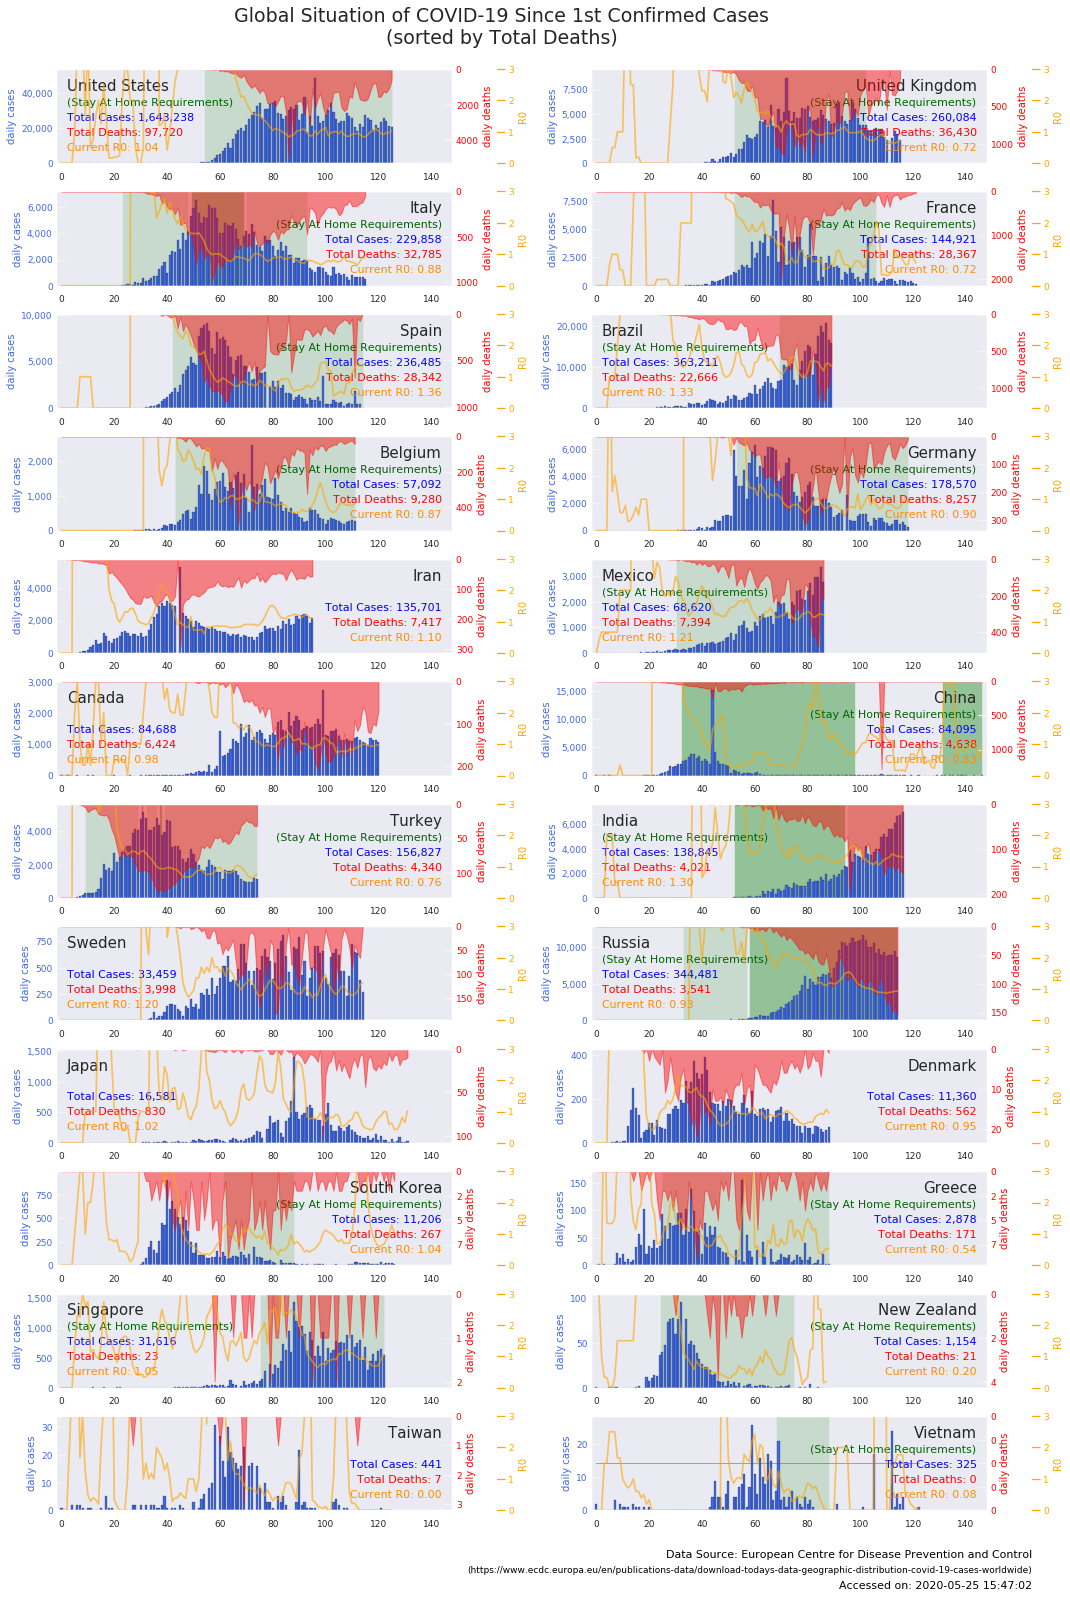

In [28]:
warnings.filterwarnings('ignore')

countries = ['United States', 'Canada', 'United Kingdom', 'Italy', 'Spain', 'France', 'Germany', 'Sweden', 'Belgium', 'Denmark', 'India', 'Russia', 'Brazil', \
             'Turkey', 'Iran', 'New Zealand', 'Greece', 'China', 'Taiwan', 'Singapore', 'South Korea', 'Japan', 'Mexico', 'Vietnam']
# countries = ['Syria', 'Yemen', 'Turkey', 'Saudi Arabia', 'Oman', 'Iraq', 'Lebanon', 'Sudan', 'Somalia'] # For further study
metrics = ['covid_cases', 'covid_deaths', 'R0']
sort_metric = metrics[1]
idx = 'days_1st_case'
gov_interv = 'c6_stay_at_home_requirements'
gov_interv_label = f"({''.join(list(gov_interv)[gov_interv.find('_')+1:]).replace('_',' ').title()})"
df = daily_covid_govresponse_df[daily_covid_govresponse_df.country.isin(countries)][daily_covid_govresponse_df.days_1st_case>=0].copy()

# Rank countries by total covid_cases
countries = (df[['country', sort_metric]].groupby('country').sum().sort_values(sort_metric, ascending=False).index)

df = df.sort_values(['country', 'date_reported'], ascending=False)
sns.set(style="dark")
fig = plt.figure(figsize=[15, math.ceil(len(countries)/2)*3.6])

for c in range(len(countries)):
    if sum(daily_covid_govresponse_df.country.unique()==countries[c])>0:
        country_df = df[df.country==countries[c]]
        country_dict = {}.fromkeys(metrics)
        gov_interv_df = country_df[[idx, gov_interv]].set_index(idx, drop=True)
        gov_interv_df = gov_interv_df[gov_interv_df.index>=0]
        
        for m in range(len(metrics)):
            data = country_df[[idx, metrics[m]]].set_index(idx, drop=True)
            data = data[data.index>=0]
            data = pd.Series(data=data[metrics[m]], index=data.index, name=countries[c]).fillna(0)
            metric_label = metrics[m].replace('_',' ').title()
            total_num = sum(data) if metrics[m] !='R0' else data.iloc[0]
            country_dict[metrics[m]] = [metric_label, total_num, data]
        
        color = 'royalblue'
        ax = fig.add_subplot(len(countries),2,c+1)
        ax.set_xlim(-2, df[idx].max()+2)
        ax.set_ylim(bottom=0, top=country_dict[metrics[0]][2].max()*1.1)
        ax.yaxis.get_major_locator().set_params(nbins=4)
        ax.set_yticklabels(['{:,.0f}'.format(i) for i in ax.get_yticks()])
        ax.tick_params(axis='x', size=9, labelsize=9, pad=0)
        ax.tick_params(axis='y', color='whitesmoke', labelcolor=color, size=9, labelsize=9, direction='in', length=0)        
        
        for v in [i for i in list(np.arange(gov_interv_df[gov_interv].max()+1)) if i >=2]:
            ax.fill_between(gov_interv_df.index, 0, country_dict[metrics[0]][2].max()*1.1, where=gov_interv_df[gov_interv]==v, facecolor='green', alpha=(v-1)*0.22-0.07)
        
        ax.set_ylabel(metrics[0].replace('covid_','daily '), color=color, fontsize=10)
        ax.bar(x=country_dict[metrics[0]][2].index, height=country_dict[metrics[0]][2], color=color, linewidth=0.2, edgecolor='black')
        plt.title(' ')
        
        # Set text location within individual axis dynamically
        txt_loc = df.days_1st_case.max()-2 if int(country_df[country_df[metrics[0]]==country_dict[metrics[0]][2].max()].days_1st_case <= ax.get_xticks()[-1]/2) == 1 else 2
        ha = 'right' if int(country_df[country_df[metrics[0]]==country_dict[metrics[0]][2].max()].days_1st_case <= ax.get_xticks()[-1]/2) == 1 else 'left'
        ax.text(txt_loc, country_dict[metrics[0]][2].max()*.85, countries[c], fontsize=15, ha=ha)
        ax.text(txt_loc, country_dict[metrics[0]][2].max()*.675, gov_interv_label, fontsize=11, color='darkgreen', ha=ha) if gov_interv_df[gov_interv].max()>=2 else None
        ax.text(txt_loc, country_dict[metrics[0]][2].max()*.5, f'Total Cases: {country_dict[metrics[0]][1]:,}', color='blue', fontsize=11, ha=ha)
        ax.text(txt_loc, country_dict[metrics[0]][2].max()*.325, f'Total Deaths: {country_dict[metrics[1]][1]:,}', color='red', fontsize=11, ha=ha)   
        ax.text(txt_loc, country_dict[metrics[0]][2].max()*.15, f'Current R0: {country_dict[metrics[2]][1]:.2f}', color='darkorange', fontsize=11, ha=ha)   
        
        color = 'red'
        ax2 = ax.twinx()
        ax2.stackplot(country_dict[metrics[1]][2].index, -country_dict[metrics[1]][2], color=color, alpha=0.45)
        ax2.set_ylabel(metrics[1].replace('covid_','daily '), color=color, rotation=90, fontsize=10)
        ax2.set_ylim(top=0, bottom=-country_dict[metrics[1]][2].max()*1.07)        
        ax2.tick_params(axis='y', color='whitesmoke', labelcolor=color, size=9, labelsize=9, direction='in')
        ax2.yaxis.get_major_locator().set_params(nbins=4)        
        ax2.set_yticklabels(['{}'.format(str(int(label)).replace('-','')) for label in ax2.get_yticks()])
        ax2.spines['right'].set_visible(True)
        
        color = 'orange'
        ax3 = ax.twinx()
        ax3.set_ylabel(metrics[2], color=color, rotation=90, fontsize=10)
        ax3.plot(country_dict[metrics[2]][2].index, country_dict[metrics[2]][2], '-', color=color, linewidth=1.7, alpha=.6)
        ax3.tick_params(axis='y', colors=color, size=9, labelsize=9)
        ax3.set_ylim(bottom=0, top=3)
        ax3.yaxis.get_major_locator().set_params(nbins=4)
        ax3.yaxis.set_major_locator(ticker.AutoLocator())
        ax3.spines['right'].set_position(('axes', 1.11))
        ax3.spines['right'].set_visible(True)
        
    else:
        print(f'{countries[c]} does not exist.')

# Add data source to the bottom        
t = str(start_time)[:str(datetime.now()).find('.')]
institute = 'European Centre for Disease Prevention and Control'
url = 'https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide'
plt.text(x=165, y=-1.5, s=f'Data Source: {institute}', color='Black', fontsize=11, ha='right')
plt.text(x=165, y=-2, s=f'({url})', color='Black', fontsize=9, ha='right')
plt.text(x=165, y=-2.5, s=f'Accessed on: {t}', color='Black', fontsize=11, ha='right')

fig.tight_layout()
plt.suptitle('Global Situation of COVID-19 Since 1st Confirmed Cases\n(sorted by Total {})'.format(sort_metric.replace('covid_','').title()), fontsize=19, x=0.47, y=0.96)        
plt.subplots_adjust(wspace=0.35, hspace=0.3, top=.94)
plt.savefig('Global Situation of COVID19 Since 1st Confirmed Cases.png', dpi=300)

# Foursquare

#### Extract Venue Category Hierarchy

In [29]:
# Assign CLIENT_ID & CLIENT_SECRET for Foursquare API

CLIENT_ID = <'Your CLIENT_ID'>
CLIENT_SECRET = <'Your CLIENT_SECRET'>

In [30]:
# Returns a hierarchical list of categories applied to venues from Foursquare site via API calls.
# Five levels of categories have been identified.

warnings.filterwarnings('ignore')

params = dict(client_id = CLIENT_ID, client_secret = CLIENT_SECRET, v='20200422')
# response = requests.get('https://api.foursquare.com/v2/venues/categories', params).json()
# with open("venue_categories_hierarchy.json", "w") as write_file:
#     json.dump(response, write_file)
response = pd.read_json('venue_categories_hierarchy.json') # To load in response json file from workspace without making an API call to Foursquare

# Create categories_tree_df_1
categories_tree = response['response']['categories']
categories_tree_df_1 = json_normalize(categories_tree)
categories_tree_df_1 = categories_tree_df_1.loc[:,['id', 'name', 'categories']]
categories_tree_df_1.columns = pd.Series(categories_tree_df_1.columns).apply(lambda x: x+'_1')

def create_subcategories_df(df):

    col_names = list(df.columns) + list(pd.Series(['id', 'name', 'categories']).apply(lambda x: x+'_'+str(int(df.shape[1]/3+1))))
    subcategories_df = pd.DataFrame(columns=col_names)

    for a in np.arange(df.shape[0]):
        if df.iloc[:,-1][a] != '':
            for b in np.arange(len(df.iloc[:,-1][a])):
                row = df.iloc[a]
                row = row.append(pd.Series(df.iloc[:,-1][a][b]['id'],index=[col_names[-3]]))
                row = row.append(pd.Series(df.iloc[:,-1][a][b]['name'],index=[col_names[-2]]))
                row = row.append(
                    pd.Series([df.iloc[:,-1][a][b]['categories']],index=[col_names[-1]]) if len(pd.Series(df.iloc[:,-1][a][b]['categories']))>0 else pd.Series('',index=[col_names[-1]])                    )
                row.index = col_names
                subcategories_df = subcategories_df.append(row, ignore_index=True)
        else:
            row = df.iloc[a]
            row = row.append(pd.Series('',index=[col_names[-3]]))
            row = row.append(pd.Series('',index=[col_names[-2]]))
            row = row.append(pd.Series('',index=[col_names[-1]]))
            row.index = col_names
            subcategories_df = subcategories_df.append(row, ignore_index=True)

    return subcategories_df

In [31]:
# Create the dataframe to store the entire hierarchy of Foursquare venue categories.

warnings.filterwarnings('ignore')

categories_tree_df_2 = create_subcategories_df(categories_tree_df_1)
categories_tree_df_3 = create_subcategories_df(categories_tree_df_2)
categories_tree_df_4 = create_subcategories_df(categories_tree_df_3)
categories_tree_df_5 = create_subcategories_df(categories_tree_df_4)

# Subset id & name columns into categories_tree_df.
col = ['id_1', 'name_1', 'id_2', 'name_2', 'id_3', 'name_3', 'id_4', 'name_4', 'id_5', 'name_5']
categories_tree_df = categories_tree_df_5.loc[:,col]
categories_tree_df.columns = pd.Series(categories_tree_df.columns).apply(lambda x: x.replace('name', 'categories'))
categories_tree_df.to_csv('categories_tree_df.csv', index=False)

print(f'categories_tree_df_1: {categories_tree_df_1.shape}')
print(f'categories_tree_df_2: {categories_tree_df_2.shape}')
print(f'categories_tree_df_3: {categories_tree_df_3.shape}')
print(f'categories_tree_df_4: {categories_tree_df_4.shape}')
print(f'categories_tree_df_5: {categories_tree_df_5.shape}')
print()
print(categories_tree_df_1.iloc[:,1])
print()
categories_tree_df.iloc[[345]]

categories_tree_df_1: (10, 3)
categories_tree_df_2: (459, 6)
categories_tree_df_3: (777, 9)
categories_tree_df_4: (858, 12)
categories_tree_df_5: (870, 15)

0           Arts & Entertainment
1           College & University
2                          Event
3                           Food
4                 Nightlife Spot
5          Outdoors & Recreation
6    Professional & Other Places
7                      Residence
8                 Shop & Service
9             Travel & Transport
Name: name_1, dtype: object



id_1 categories_1                      id_2  \
345  4d4b7105d754a06374d81259         Food  4bf58dd8d48988d1be941735   

                  categories_2                      id_3  \
345  Latin American Restaurant  4bf58dd8d48988d1cd941735   

                  categories_3                      id_4  \
345  South American Restaurant  4bf58dd8d48988d16b941735   

             categories_4                      id_5  \
345  Brazilian Restaurant  52939ab93cf9994f4e043a38   

                      categories_5  
345  Northern Brazilian Restaurant

#### Create Flat Reference Table for Venue Categories

In [32]:
# Create categories_id_df as a flat reference for all Foursquare venue categories, category_level, and id.

categories_id_df = pd.DataFrame(columns=['id', 'lev', 'categories'])

for i in np.arange(1,6):
    id_ls = categories_tree_df['id_'+str(i)].drop_duplicates()
    level_ls = [i] * len(id_ls)
    categories_ls = categories_tree_df['categories_'+str(i)].drop_duplicates()
    sub_df = pd.concat([pd.DataFrame(id_ls).reset_index(drop=True), pd.DataFrame(level_ls).reset_index(drop=True), pd.DataFrame(categories_ls).reset_index(drop=True)], axis=1)\
    .reset_index(drop=True)
    sub_df.columns = 'id', 'lev', 'categories'
    categories_id_df = categories_id_df.append(sub_df, ignore_index=True)

categories_id_df = categories_id_df[categories_id_df.id!='']
categories_id_df.set_index('id', inplace=True)

print(f'categories_id_df.shape: {categories_id_df.shape}')
# categories_id_df.info()
categories_id_df.head(1)

categories_id_df.shape: (943, 2)


lev            categories
id                                                
4d4b7104d754a06370d81259   1  Arts & Entertainment

#### Extract Metro Stations of the Five Hardest Hit Major Cities & Nearby Venues

1. London
2. New York City
3. Paris
4. Madrid
5. Berlin

In [33]:
# This function defines the tasks extracting venue data from Foursquare site via API calls for each station on the input dataframe. 
# All venues for individual stations are combined into one master_venue_df.
# The Foursquare API has a limit of 950 Regular API Calls per day and 50 Premium API Calls per day for Sandbox Tier Accounts (https://developer.foursquare.com/docs/places-api/rate-limits/).
# Input dataframe should consists of the three fields: station, latitude, and longitude

def create_master_venue_df(df):

    master_venue_df = pd.DataFrame()

    for i in np.arange(df.shape[0]):
        
        print(i) # to be deleted
        loc = df.iloc[i]
        lat = float(loc.latitude)
        lon = float(loc.longitude)
        radius = 999
        limit = 100
        params = dict(
            client_id = CLIENT_ID,
            client_secret = CLIENT_SECRET,
            v = '20200421',
            radius = radius,
            limit = limit,
            ll = f'{lat},{lon}')

        response = requests.get('https://api.foursquare.com/v2/venues/explore', params).json()
        
        if response['response']['totalResults']==0:
            pass
        else:
            venues = response['response']['groups'][0]['items']
            venues_df = json_normalize(venues)

            categories_id = []
            categories = []

            for j in np.arange(venues_df.shape[0]):
                categories_id = categories_id + [venues_df.iloc[j]['venue.categories'][0]['id']]
                categories = categories + [venues_df.iloc[j]['venue.categories'][0]['name']]
            venues_df.insert(loc=list(venues_df.columns).index('venue.categories'), column='venue_categories_id', value=pd.Series(categories_id))
            venues_df.insert(loc=list(venues_df.columns).index('venue.categories'), column='venue_categories', value=pd.Series(categories))
            venues_df.insert(loc=0, column='stn_longitude', value=pd.Series([loc.longitude] * venues_df.shape[0]))
            venues_df.insert(loc=0, column='stn_latitude', value=pd.Series([loc.latitude] * venues_df.shape[0]))
            venues_df.insert(loc=0, column='station', value=pd.Series([loc.station] * venues_df.shape[0]))

            col = ['station', 'stn_latitude', 'stn_longitude', 'venue.name', 'venue.location.lat', 'venue.location.lng', 'venue_categories', 'venue_categories_id']
            venues_df = venues_df.loc[:,col]
            venues_df = venues_df.rename(
                columns={
                    'venue.name':'venue',
                    'venue.location.lat':'venue_lat',
                    'venue.location.lng':'venue_lon'})
            master_venue_df = master_venue_df.append(venues_df, ignore_index=True)

    return master_venue_df

In [34]:
# Scrape 'List of London Underground stations' from OpenStreetMap Wiki site

source = requests.get('https://wiki.openstreetmap.org/wiki/List_of_London_Underground_stations').text
soup = BeautifulSoup(source, 'lxml')
ldn_tube_df = pd.DataFrame()

for tr in soup.find('table').find_all('tr'):
    ldn_tube_df = ldn_tube_df.append([tr.text.split('\n')], ignore_index=True)
    
col = ldn_tube_df.iloc[0]
col = col[1:8]
ldn_tube_df.drop(index=0, inplace=True)
idx = [0,2,4,6,8,10,12,14,15,16]
ldn_tube_df.drop(columns=idx, inplace=True)
ldn_tube_df.columns = col
ldn_tube_df.reset_index(drop=True, inplace=True)
ldn_tube_df = ldn_tube_df.iloc[:,0:3]
ldn_tube_df.columns = 'station', 'latitude', 'longitude'

for i in ldn_tube_df.index:
    ldn_tube_df.iloc[i].latitude = ''.join(list(ldn_tube_df.iloc[i].latitude)[0:ldn_tube_df.iloc[i].latitude.find(' ')])
    ldn_tube_df.iloc[i].longitude = ''.join(list(ldn_tube_df.iloc[i].longitude)[0:ldn_tube_df.iloc[i].longitude.find(' ')])

ldn_tube_df = ldn_tube_df.astype({'latitude':'float', 'longitude':'float'})
ldn_tube_df.drop_duplicates(subset='station', keep='first', inplace=True, ignore_index=True)
ldn_tube_df.reset_index(drop=True, inplace=True)
ldn_tube_df.info()
ldn_tube_df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    291 non-null    object 
 1   latitude   291 non-null    float64
 2   longitude  291 non-null    float64
dtypes: float64(2), object(1)
memory usage: 6.9+ KB


station  latitude  longitude
0  Acton Town   51.5025   -0.27812

In [35]:
# Extract '2015 New York City Subway Stations' json file from NYU Spatial Data Repository

nyc_subway_df = pd.DataFrame()
response = requests.get('https://geo.nyu.edu/download/file/nyu-2451-34503-geojson.json').json()
properties = response['features']
nyc_subway_df = pd.json_normalize(properties)

nyc_subway_df = nyc_subway_df[['properties.stop_id', 'properties.stop_name', 'properties.stop_lat', 'properties.stop_lon']]
nyc_subway_df.columns = 'station_id', 'station', 'latitude', 'longitude'
nyc_subway_df['station'] = nyc_subway_df['station_id'] + '_' + nyc_subway_df['station'].str.replace(' - ','_').str.replace(' ','_')
nyc_subway_df = nyc_subway_df[['station', 'latitude', 'longitude']]
nyc_subway_df = nyc_subway_df.astype({'latitude':'float', 'longitude':'float'})
nyc_subway_df.drop_duplicates(subset='station', keep='first', inplace=True, ignore_index=True)
nyc_subway_df.reset_index(drop=True, inplace=True)

nyc_subway_df.info()
nyc_subway_df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    491 non-null    object 
 1   latitude   491 non-null    float64
 2   longitude  491 non-null    float64
dtypes: float64(2), object(1)
memory usage: 11.6+ KB


station   latitude  longitude
0  101_Van_Cortlandt_Park_242_St  40.889248 -73.898583

In [36]:
# Scrape 'List of Paris Métro stations' from Wikipedia site and append station coordinates from Nominatim.

paris_metro_df = pd.DataFrame()
station_ls = []
source = requests.get('https://en.wikipedia.org/wiki/List_of_Paris_M%C3%A9tro_stations').text
soup = BeautifulSoup(source, 'lxml')

for tr in soup.find('table').tbody.find_all('tr'):
    station = tr.text.split('\n')
    station_ls = station_ls + [station]

paris_metro_df = paris_metro_df.append(station_ls, ignore_index=True)
paris_metro_s = paris_metro_df.iloc[1:,1].reset_index(drop=True)
paris_metro_s.name = 'station'
paris_metro_df = pd.DataFrame(paris_metro_s)
paris_metro_df.drop_duplicates(subset='station', keep='first', inplace=True, ignore_index=True)
paris_metro_df.reset_index(drop=True, inplace=True)

geolocater = Nominatim(user_agent='paris_explorer')
lat = []
lon = []

for stn in paris_metro_s:
    add = stn + ' station'
    location = geolocater.geocode(add, timeout=10)
    if location is None:
        lat = lat + [np.nan]
        lon = lon + [np.nan]
    else:
        lat = lat + [location.latitude]
        lon = lon + [location.longitude]

paris_metro_df['latitude'], paris_metro_df['longitude'] = lat, lon

paris_metro_df.info()
paris_metro_df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    304 non-null    object 
 1   latitude   304 non-null    float64
 2   longitude  304 non-null    float64
dtypes: float64(2), object(1)
memory usage: 7.2+ KB


station   latitude  longitude
0  Abbesses  48.884568   2.337929

In [37]:
# Scrape list of Madrid metro stations from Medro de Madrid site and append station coordinates from Nominatim.

warnings.filterwarnings('ignore')

n = list('linea-' + pd.Series(np.arange(1,13)).astype('str'))+['ramal']
madrid_metro_df = pd.DataFrame(columns=['station', 'latitude', 'longitude'])

for i in n:
    
    station_ls = []
    url = f'https://www.metromadrid.es/en/linea/{i}'
    source = requests.get(url).text
    soup = BeautifulSoup(source, 'lxml')

    for p in soup.find_all('p', class_='list-line__btn__text'):
        station = p.text
        station_ls = station_ls + [station]

    sub_metro_s = pd.Series(station_ls)
    sub_metro_s.name = 'station'
    sub_metro_df = pd.DataFrame(sub_metro_s)

    geolocater = Nominatim(user_agent='madrid_explorer')
    lat = []
    lon = []

    for stn in sub_metro_s:
        add = stn + ' station'
        location = geolocater.geocode(add, timeout=10)
        if location is None:
            lat = lat + [np.nan]
            lon = lon + [np.nan]
        else:
            lat = lat + [location.latitude]
            lon = lon + [location.longitude]

    sub_metro_df['latitude'], sub_metro_df['longitude'] = lat, lon
    madrid_metro_df = madrid_metro_df.append(sub_metro_df, ignore_index=True)

madrid_metro_df.drop_duplicates(subset='station', keep='first', inplace=True, ignore_index=True)
madrid_metro_df.reset_index(drop=True, inplace=True)
    
madrid_metro_df.info()
madrid_metro_df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    201 non-null    object 
 1   latitude   201 non-null    float64
 2   longitude  201 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.8+ KB


station  latitude  longitude
0  Pinar de Chamartín  40.48005  -3.667052

In [38]:
# Scrape list of Berlin metro stations from Wikipedia site and append station coordinates from Nominatim.

berlin_metro_df = pd.DataFrame()
for t in ['U', 'S']:
    
    url = f'https://en.wikipedia.org/wiki/List_of_Berlin_{t}-Bahn_stations'
    source = requests.get(url).text
    soup = BeautifulSoup(source, 'lxml')
    sub_metro_df = pd.DataFrame()
    station_ls = []

    for td in soup.find_all('td', align="left"):
        station = td.text.split('\n')
        station_ls = station_ls + [station]

    sub_metro_df = sub_metro_df.append(station_ls, ignore_index=True)
    berlin_metro_s = sub_metro_df.iloc[:,0].reset_index(drop=True)
    berlin_metro_s = pd.Series(str.replace('\xa0[de]','') for str in berlin_metro_s)
    berlin_metro_s.name = 'station'
    berlin_metro_df = berlin_metro_df.append(pd.DataFrame(berlin_metro_s), ignore_index=True)
    
geolocater = Nominatim(user_agent='berlin_explorer')
lat = []
lon = []

for stn in berlin_metro_df.station:
    add = stn + ' station'
    location = geolocater.geocode(add, timeout=10)
    if location is None:
        lat = lat + [np.nan]
        lon = lon + [np.nan]
    else:
        lat = lat + [location.latitude]
        lon = lon + [location.longitude]

berlin_metro_df['latitude'], berlin_metro_df['longitude'] = lat, lon
berlin_metro_df.drop_duplicates(subset='station', keep='first', inplace=True, ignore_index=True)
berlin_metro_df.reset_index(drop=True, inplace=True)
berlin_metro_df = berlin_metro_df[berlin_metro_df.latitude.notna()]

berlin_metro_df.info()
berlin_metro_df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327 entries, 0 to 331
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    327 non-null    object 
 1   latitude   327 non-null    float64
 2   longitude  327 non-null    float64
dtypes: float64(2), object(1)
memory usage: 10.2+ KB


station   latitude  longitude
0  Adenauerplatz  52.500567  13.307021

In [39]:
# ldn_venue_df = create_master_venue_df(ldn_tube_df)
# ldn_venue_df.info()
# ldn_venue_df.to_csv('ldn_venue_df.csv', index=False)

# nyc_venue_df = create_master_venue_df(nyc_subway_df)
# nyc_venue_df.info()
# nyc_venue_df.to_csv('nyc_venue_df.csv', index=False)

# paris_venue_df = create_master_venue_df(paris_metro_df)
# paris_venue_df.info()
# paris_venue_df.to_csv('paris_venue_df.csv', index=False)

# madrid_venue_df = create_master_venue_df(madrid_metro_df)
# madrid_venue_df.info()
# madrid_venue_df.to_csv('madrid_venue_df.csv', index=False)

# berlin_venue_df = create_master_venue_df(berlin_metro_df)
# berlin_venue_df.info()
# berlin_venue_df.to_csv('berlin_venue_df.csv', index=False)

# Read in csv files stored in the workspace which were previously generated using Foursquare API calls.
ldn_venue_df = pd.read_csv('ldn_venue_df.csv')
nyc_venue_df = pd.read_csv('nyc_venue_df.csv')
paris_venue_df = pd.read_csv('paris_venue_df.csv')
madrid_venue_df = pd.read_csv('madrid_venue_df.csv')
berlin_venue_df = pd.read_csv('berlin_venue_df.csv')

print(f'ldn_tube_df: {ldn_tube_df.station.count()} / ldn_venue_df: {ldn_venue_df.shape[0]} / Venues per station: {ldn_venue_df.shape[0]/ldn_tube_df.station.count():.2f}')
print(f'nyc_subway_df: {nyc_subway_df.station.count()} / nyc_venue_df: {nyc_venue_df.shape[0]} / Venues per station: {nyc_venue_df.shape[0]/nyc_subway_df.station.count():.2f}')
print(f'paris_metro_df: {paris_metro_df.station.count()} / paris_venue_df: {paris_venue_df.shape[0]} / Venues per station: {paris_venue_df.shape[0]/paris_metro_df.station.count():.2f}')
print(f'madrid_metro_df: {madrid_metro_df.station.count()} / madrid_venue_df: {madrid_venue_df.shape[0]} / Venues per station: {madrid_venue_df.shape[0]/madrid_metro_df.station.count():.2f}')
print(f'berlin_metro_df: {berlin_metro_df.station.count()} / berlin_venue_df: {berlin_venue_df.shape[0]} / Venues per station: {berlin_venue_df.shape[0]/berlin_metro_df.station.count():.2f}')

ldn_tube_df: 291 / ldn_venue_df: 18864 / Venues per station: 64.82
nyc_subway_df: 491 / nyc_venue_df: 42316 / Venues per station: 86.18
paris_metro_df: 304 / paris_venue_df: 22476 / Venues per station: 73.93
madrid_metro_df: 201 / madrid_venue_df: 12745 / Venues per station: 63.41
berlin_metro_df: 327 / berlin_venue_df: 12870 / Venues per station: 39.36


In [40]:
nyc_venue_df.info()
nyc_venue_df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42316 entries, 0 to 42315
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station              42316 non-null  object 
 1   stn_latitude         42316 non-null  float64
 2   stn_longitude        42316 non-null  float64
 3   venue                42316 non-null  object 
 4   venue_lat            42316 non-null  float64
 5   venue_lon            42316 non-null  float64
 6   venue_categories     42316 non-null  object 
 7   venue_categories_id  42316 non-null  object 
dtypes: float64(4), object(4)
memory usage: 2.6+ MB


station  stn_latitude  stn_longitude  \
0  101_Van_Cortlandt_Park_242_St     40.889248     -73.898583   

                              venue  venue_lat  venue_lon venue_categories  \
0  Van Cortlandt Park Running Track  40.888341 -73.897648            Track   

        venue_categories_id  
0  4bf58dd8d48988d106941735

#### Flag Venues Per Lockdown Rules & Google Community Mobility Classification

In [41]:
# Add flags of closed venues for restrictions on internal movement & school closing to categories_id_df.
# Add flags for venue classifications defined in 'Google COVID-19 Community Mobility Reports'.

# Venues closed for restrictions on internal movement
closed_venues = [
    '4d4b7104d754a06370d81259',
    '4d4b7105d754a06373d81259',
    '4d4b7105d754a06374d81259',
    '4d4b7105d754a06376d81259',
    '4d4b7105d754a06377d81259',
    '4d4b7105d754a06375d81259',
    '4d4b7105d754a06379d81259',
    '4d4b7105d754a06378d81259']

# Venues exceptions for restrictions on internal movements
exception_venues = [
    '4f4534884b9074f6e4fb0174',
    '4bf58dd8d48988d126941735',
    '4bf58dd8d48988d104941735',
    '58daa1548bbb0b01f18ec1a9',
    '5310b8e5bcbc57f1066bcbf1',
    '5032856091d4c4b30a586d63',
    '52e81612bcbc57f1066b7a31',
    '58daa1558bbb0b01f18ec1ac',
    '4d954b0ea243a5684a65b473',
    '5745c2e4498e11e7bccabdbd',
    '56aa371be4b08b9a8d573550',
    '4bf58dd8d48988d118951735',
    '52f2ab2ebcbc57f1066b8b45',
    '52f2ab2ebcbc57f1066b8b46',
    '52f2ab2ebcbc57f1066b8b1c',
    '4bf58dd8d48988d113951735',
    '58daa1558bbb0b01f18ec206',
    '4bf58dd8d48988d10f951735',
    '5032897c91d4c4b30a586d69',
    '4bf58dd8d48988d100951735',
    '52e816a6bcbc57f1066b7a54']

# Venues closed for school closing
school_venues = [
    '4d4b7105d754a06372d81259',
    '4f4533804b9074f6e4fb0105',
    '4bf58dd8d48988d13d941735',
    '4f4533814b9074f6e4fb0107',
    '52e81612bcbc57f1066b7a45',
    '52e81612bcbc57f1066b7a46',
    '52e81612bcbc57f1066b7a47',
    '4bf58dd8d48988d1ae941735']

# Translate Foursquare venue classification to Google venue classification defined in 'Google COVID-19 Community Mobility Reports'.
goog_grocery_pharmacy = ['4bf58dd8d48988d104941735',
                    '4d954b0ea243a5684a65b473',
                    '5745c2e4498e11e7bccabdbd',
                    '52f2ab2ebcbc57f1066b8b1c',
                    '58daa1558bbb0b01f18ec206',
                    '4bf58dd8d48988d10f951735',
                    '52e816a6bcbc57f1066b7a54',
                    '4bf58dd8d48988d118951735',
                    '56aa371be4b08b9a8d573550',
                    '50aa9e744b90af0d42d5de0e',
                    '52f2ab2ebcbc57f1066b8b45',
                    '52f2ab2ebcbc57f1066b8b46']

goog_parks_outdoors = ['4d4b7105d754a06377d81259']

goog_transit_stations = ['4bf58dd8d48988d1ed931735',
                         '4e4c9077bd41f78e849722f9',
                         '4bf58dd8d48988d12d951735',
                         '4bf58dd8d48988d1fe931735',
                         '52f2ab2ebcbc57f1066b8b4f',
                         '52f2ab2ebcbc57f1066b8b50',
                         '55077a22498e5e9248869ba2',
                         '4bf58dd8d48988d1fc931735',
                         '4bf58dd8d48988d1fd931735',
                         '4e74f6cabd41c4836eac4c31',
                         '56aa371be4b08b9a8d57353e',
                         '53fca564498e1a175f32528b',
                         '4bf58dd8d48988d130951735',
                         '52f2ab2ebcbc57f1066b8b4d',
                         '52f2ab2ebcbc57f1066b8b4e',
                         '4bf58dd8d48988d129951735',
                         '52f2ab2ebcbc57f1066b8b51',
                         '54541b70498ea6ccd0204bff',
                         '52f2ab2ebcbc57f1066b8b4a',
                         '4bf58dd8d48988d1ef931735',
                         '4bf58dd8d48988d1f0931735',
                         '4eb1bc533b7b2c5b1d4306cb',
                         '56aa371be4b08b9a8d57352f',
                         '4bf58dd8d48988d1eb931735',
                         '4bf58dd8d48988d1ec931735',
                         '5744ccdfe4b0c0459246b4e5',
                         '4bf58dd8d48988d1f7931735',
                         '4bf58dd8d48988d12b951735',
                         '4f4531504b9074f6e4fb0102',
                         '4bf58dd8d48988d12a951735']


goog_retail_recreation = ['4d4b7104d754a06370d81259',
                     '4d4b7105d754a06373d81259',
                     '4d4b7105d754a06374d81259',
                     '4d4b7105d754a06376d81259',
                     '4d4b7105d754a06378d81259']

goog_workplaces = ['4d4b7105d754a06375d81259']

goog_residential = ['4e67e38e036454776db1fb3a']

id_level_1_ls = []
id_ls = []

for id in categories_id_df.index:
    lev = categories_id_df.loc[id]['lev']
    id_col = 'id_' + str(lev)
    id_level_1 = list(categories_tree_df[categories_tree_df[id_col]==id].id_1)[0]
    id_level_1_ls = id_level_1_ls + [id_level_1]
    id_ls = id_ls + [id]
    
bool_1 = pd.Series(id_level_1_ls).isin(closed_venues)
bool_2 = pd.Series(id_ls).isin(exception_venues + school_venues)
domestic_travel = pd.concat([bool_1,bool_2], axis=1).apply(lambda x: x[0] != x[1] if x[0] else x[0], axis=1)
domestic_travel.index = categories_id_df.index
categories_id_df.insert(loc = len(categories_id_df.columns), column='domestic_travel_ban', value=domestic_travel.astype('int'))

school_closing = pd.Series(id_ls, index=categories_id_df.index).isin(school_venues)
categories_id_df.insert(loc = len(categories_id_df.columns), column='school_closing', value=school_closing.astype('int'))
categories_id_df['goog_grocery_pharmacy'] = list(int(i) for i in pd.Series(id_ls).isin(goog_grocery_pharmacy) + pd.Series(id_level_1_ls).isin(goog_grocery_pharmacy))
categories_id_df['goog_parks_outdoors'] = list(int(i) for i in pd.Series(id_ls).isin(goog_parks_outdoors) + pd.Series(id_level_1_ls).isin(goog_parks_outdoors))
categories_id_df['goog_transit_stations'] = list(int(i) for i in pd.Series(id_ls).isin(goog_transit_stations) + pd.Series(id_level_1_ls).isin(goog_transit_stations))
categories_id_df['goog_retail_recreation'] = list(int(i) for i in pd.Series(id_ls).isin(goog_retail_recreation) + pd.Series(id_level_1_ls).isin(goog_retail_recreation))
categories_id_df['goog_workplaces'] = list(int(i) for i in pd.Series(id_ls).isin(goog_workplaces) + pd.Series(id_level_1_ls).isin(goog_workplaces))
categories_id_df['goog_residential'] = list(int(i) for i in pd.Series(id_ls).isin(goog_residential) + pd.Series(id_level_1_ls).isin(goog_residential))

categories_id_df.head(1)

lev            categories  domestic_travel_ban  \
id                                                                        
4d4b7104d754a06370d81259   1  Arts & Entertainment                    1   

                          school_closing  goog_grocery_pharmacy  \
id                                                                
4d4b7104d754a06370d81259               0                      0   

                          goog_parks_outdoors  goog_transit_stations  \
id                                                                     
4d4b7104d754a06370d81259                    0                      0   

                          goog_retail_recreation  goog_workplaces  \
id                                                                  
4d4b7104d754a06370d81259                       1                0   

                          goog_residential  
id                                          
4d4b7104d754a06370d81259                 0

#### Comparison of the Five Hardest Hit Major Cities

In [42]:
# Top 10 venues of each major city

# Create grouped_df to store category dummies for all venues by city.
ldn_venue_df['city'] = 'London'
nyc_venue_df['city'] = 'New York City'
paris_venue_df['city'] = 'Paris'
madrid_venue_df['city'] = 'Marid'
berlin_venue_df['city'] = 'Berlin'

country_venue_df_ls = [ldn_venue_df, nyc_venue_df, paris_venue_df, madrid_venue_df, berlin_venue_df]
five_city_venues_df = pd.concat(country_venue_df_ls, axis=0)

df = five_city_venues_df.copy()
dummy_df = pd.get_dummies(df.venue_categories)
dummy_col = dummy_df.columns
grouped_df = df.iloc[:,[0,1,2,3,-1]].merge(dummy_df, how='left', left_index=True, right_index=True).groupby('city').mean()

# Rank top 10 venues for each city based on venue values on grouped_df, and create top_venues_df to show the result.
top_venues_df = pd.DataFrame()
col_ls = []

for t in np.arange(1,11):
    if t==1:
        col_ls = col_ls + ['Top '+str(t)+'st Venues']
    elif t==2:
        col_ls = col_ls + ['Top '+str(t)+'nd Venues']
    elif t==3:
        col_ls = col_ls + ['Top '+str(t)+'rd Venues']
    else:
        col_ls = col_ls + ['Top '+str(t)+'th Venues']

for i in np.arange(grouped_df.shape[0]):
    s = [grouped_df.iloc[i][3:].sort_values(ascending=False).head(10).index]
    top_venues_df = top_venues_df.append(s)

top_venues_df.columns = col_ls
top_venues_df['city'] = grouped_df.index
top_venues_df.set_index('city', inplace=True)
top_venues_df

Top 1st Venues     Top 2nd Venues     Top 3rd Venues  \
city                                                                     
Berlin                     Hotel               Café  French Restaurant   
London                     Hotel  French Restaurant        Coffee Shop   
Marid                      Hotel               Café  French Restaurant   
New York City              Hotel  French Restaurant        Coffee Shop   
Paris          French Restaurant              Hotel        Coffee Shop   

              Top 4th Venues      Top 5th Venues Top 6th Venues  \
city                                                              
Berlin           Coffee Shop  Italian Restaurant    Pizza Place   
London                  Café  Italian Restaurant    Pizza Place   
Marid            Coffee Shop  Italian Restaurant    Pizza Place   
New York City           Café  Italian Restaurant    Pizza Place   
Paris                   Café  Italian Restaurant    Pizza Place   

              Top 7th Venues Top 8th Venues Top 9th Venues Top 10th Venues  
city                                                                        
Berlin            Restaurant         Bakery            Bar     Supermarket  
London                Bakery            Bar     Restaurant            Park  
Marid             Restaurant            Bar         Bakery     Supermarket  
New York City         Bakery            Bar           Park      Restaurant  
Paris                 Bakery            Bar     Restaurant            Park

In [43]:
# Create plot_df for the five major cities to overlay 'Google COVID-19 Community Mobility Reports' against Foursquare venue data.

country_venue_df_ls = [ldn_venue_df, nyc_venue_df, paris_venue_df, madrid_venue_df, berlin_venue_df]
mean_ls = []

for df in country_venue_df_ls:
    df = df.copy()
    df = df.set_index('venue_categories_id', drop=True)
    venue_goog_df = df.merge(categories_id_df, how='left', left_index=True, right_index=True)
    mean_ls = mean_ls + [venue_goog_df.iloc[:,9:].mean()]
    mean_ls

mean_ls = np.array(mean_ls)
plot_df = pd.DataFrame(mean_ls).T
plot_df.columns = ['London', 'New York City', 'Paris', 'Madrid', 'Berlin']

plot_df = plot_df.T
plot_df.columns = categories_id_df.columns[2:]

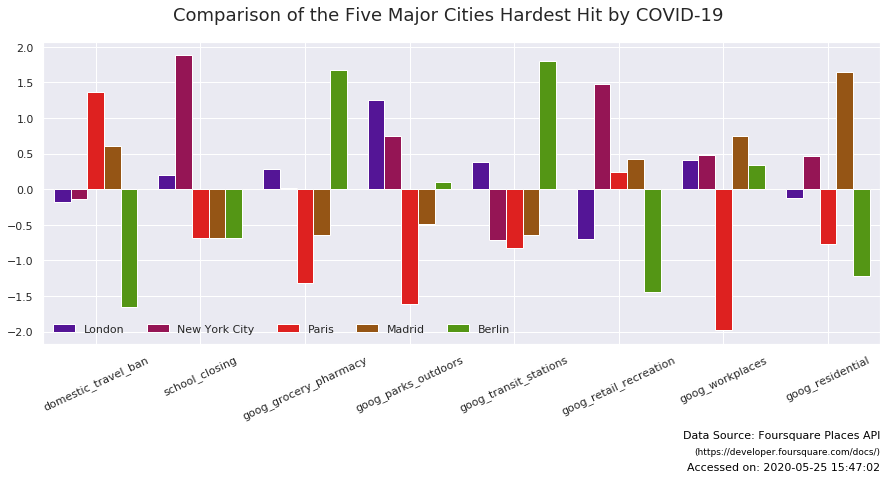

In [44]:
# Create bar chart to compare the five major cities based on 'Google COVID-19 Community Mobility Reports' venue classification.

df = plot_df.copy()
col = df.columns
idx = df.index
plot_df_t = preprocessing.StandardScaler().fit_transform(df)
plot_df_t = pd.DataFrame(plot_df_t, columns=col, index=idx)
plot_df_t.reset_index(drop=False, inplace=True)
plot_df_t.columns = ['country'] + list(col)
plot_df_t = plot_df_t.melt(id_vars='country', value_vars=list(col))

sns.set(style='darkgrid')
color = sns.color_palette('brg', df.shape[0])
fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(x='variable', y='value', hue='country', palette=color, data=plot_df_t, ax=ax)
ax.legend(ncol=5, loc=0, frameon=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25)
ax.set_ylabel('')
ax.set_xlabel('')
plt.suptitle('Comparison of the Five Major Cities Hardest Hit by COVID-19', fontsize=18, y=0.97)
plt.subplots_adjust(top=0.9, bottom=0.3)
plt.grid(True)

# Add data source to the bottom
t = str(start_time)[:str(datetime.now()).find('.')]
institute = 'Foursquare Places API'
url = 'https://developer.foursquare.com/docs/'
plt.text(x=7.5, y=-3.5, s=f'Data Source: {institute}', color='Black', fontsize=11, ha='right')
plt.text(x=7.5, y=-3.72, s=f'({url})', color='Black', fontsize=9, ha='right')
plt.text(x=7.5, y=-3.94, s=f'Accessed on: {t}', color='Black', fontsize=11, ha='right')

plt.savefig('Comparison of the Five Major Cities Hardest Hit by COVID19.png', dpi=200)

#### Google COVID-19 Community Mobility Reports

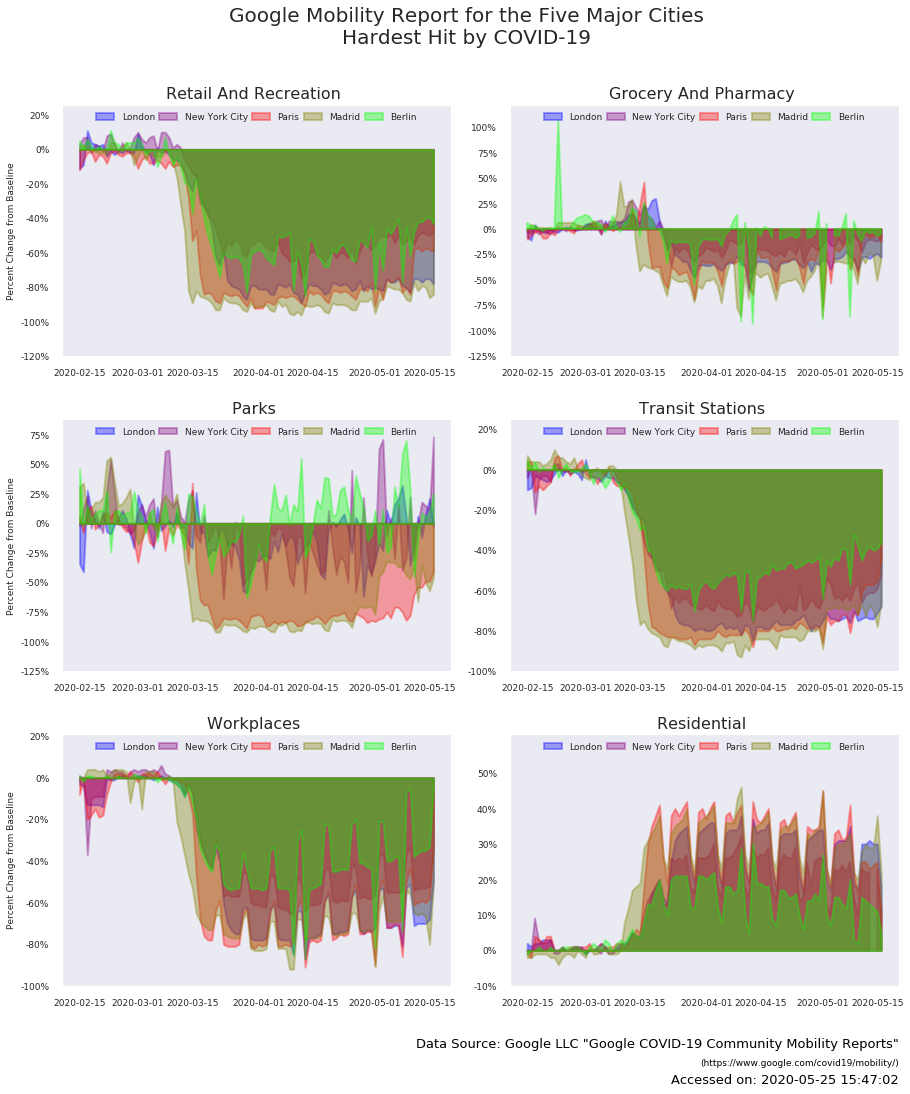

In [45]:
warnings.filterwarnings('ignore')

goog_mob_df = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')
goog_mob_df = goog_mob_df[goog_mob_df.sub_region_1.isin(['Greater London', 'New York', 'Île-de-France', 'Community of Madrid', 'Berlin'])].reset_index(drop=True)
goog_mob_df.drop(columns=['country_region', 'country_region_code','sub_region_2'], inplace=True)
goog_mob_df.date = [pd.to_datetime(x) for x in goog_mob_df.date]

sns.set(style='dark')
goog_venue_cat_ls = list(goog_mob_df.columns[2:])
cities = ['London', 'New York City', 'Paris', 'Madrid', 'Berlin']
color = colors.to_rgba_array(cm.brg(np.linspace(0,1,len(cities))))
fig = plt.figure(figsize=[15,17])

for i, cat in enumerate(goog_venue_cat_ls):        
        
    df = goog_mob_df[['sub_region_1','date',goog_venue_cat_ls[i]]].drop_duplicates(subset=['sub_region_1','date'], keep='first')
    df = df.pivot(index='date', columns='sub_region_1', values=goog_venue_cat_ls[i])
    df.columns = 'Berlin', 'Madrid', 'London', 'New York City', 'Paris'
    df = df[cities].reset_index(drop=False)
    labels = list(df.columns[1:])
    ax = plt.subplot(3,2,i+1)
         
    for a, c in enumerate(cities):
        ax.fill_between(x=df.date, y1=0, y2=df[c], alpha=.35, color=color[a], linewidth=2)
        
    ax.legend(labels=labels, ncol=len(labels), loc='upper center', frameon=False, columnspacing=0.5, fontsize=9, numpoints=9)
    ax.set_title(cat.replace('_', ' ').replace('percent change from baseline', '').title(), fontsize=16)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels('{:.0%}'.format(y/100) for y in ax.get_yticks())
    ax.set_ylim(top=df.iloc[:,1:].max().max()+15, auto=False)
    ax.set_xlabel('')
    ax.set_ylabel('Percent Change from Baseline', fontsize=9) if math.fmod(i+1,2)==1 else ax.set_ylabel('')
    ax.tick_params(axis='both', size=9, labelsize=9)
        
plt.suptitle('Google Mobility Report for the Five Major Cities\nHardest Hit by COVID-19', size=20, y=0.98)
plt.subplots_adjust(hspace=0.25, wspace=0.15, top=0.9, bottom=0.18)

# Add data source to the bottom
t = str(start_time)[:str(datetime.now()).find('.')]
institute = 'Google LLC "Google COVID-19 Community Mobility Reports"'
url = 'https://www.google.com/covid19/mobility/'
plt.figtext(x=.9, y=.13, s=f'Data Source: {institute}', color='Black', fontsize=13, ha='right')
plt.figtext(x=.9, y=.115, s=f'({url})', color='Black', fontsize=9, ha='right')
plt.figtext(x=.9, y=.1, s=f'Accessed on: {t}', color='Black', fontsize=13, ha='right')

plt.savefig('Google Mobility Report for the Five Major Citie Hardest Hit by COVID19.png', dpi=200)

# Data Normalisation for Clustering

In [46]:
# Normalise country_master_df1 for the measurements can be display on the map in a standard scale.

warnings.filterwarnings('ignore')

df = country_master_df1.dropna()
temp1 = df.iloc[:,0:2]
rm_col = ['c1_flag', 'c2_flag', 'c3_flag', 'c4_flag', 'c5_flag', 'c6_flag', 'c7_flag', 'e1_flag', 'h1_flag', 'm1_wildcard']
temp2 = df[df.columns[~pd.Series(df.columns).isin(rm_col)]].iloc[:,2:]

temp2_t = preprocessing.MinMaxScaler(feature_range=(0, 30)).fit_transform(temp2)
# temp2_t = preprocessing.StandardScaler().fit_transform(temp2)
# temp2_t = preprocessing.RobustScaler(quantile_range=(25,75)).fit_transform(temp2)
# temp2_t = preprocessing.PolynomialFeatures(2).fit_transform(temp2)

temp2_t = pd.DataFrame(temp2_t, columns=temp2.columns, index=temp2.index)
country_master_df_t = pd.concat([temp1,temp2_t], axis=1)
country_master_df_t.describe()

longitude    latitude  total_cases  total_deaths  total_recovered  \
count  140.000000  140.000000   140.000000    140.000000       140.000000   
mean    19.313274   20.318867     0.692769      0.745990         1.085059   
std     57.850018   25.219555     2.735549      3.036935         3.292073   
min   -102.534991  -41.837107     0.000000      0.000000         0.000000   
25%     -3.555580    4.422787     0.011251      0.003018         0.014210   
50%     20.647056   19.381177     0.058511      0.018713         0.098638   
75%     46.912576   41.297073     0.336999      0.155888         0.482003   
max    171.603971   64.997650    30.000000     30.000000        30.000000   

       total_tests  active_cases  serious_critical  cases_per_m  deaths_per_m  \
count   140.000000    140.000000        140.000000   140.000000    140.000000   
mean      1.010202      0.483548          0.661616     2.085754      1.895434   
std       3.183793      2.624918          3.135021     3.705119      4.661906   
min       0.000000      0.000000          0.000000     0.000000      0.000000   
25%       0.024625      0.002842          0.000000     0.101720      0.074627   
50%       0.152343      0.019644          0.012256     0.490761      0.186567   
75%       0.620750      0.145740          0.101547     2.902341      1.026119   
max      30.000000     30.000000         30.000000    30.000000     30.000000   

       tests_per_m  tests_per_case  recovery_rate  critical_rate  \
count   140.000000      140.000000     140.000000     140.000000   
mean      3.686529        2.242296      16.086817       0.922413   
std       5.643573        4.392325       8.147050       3.182112   
min       0.000000        0.000000       0.000000       0.000000   
25%       0.291849        0.275986       9.605870       0.000000   
50%       1.001704        0.722061      15.856399       0.211882   
75%       4.444503        1.814494      23.299355       0.661706   
max      30.000000       30.000000      30.000000      30.000000   

       population_2020  density_p_km2  migrants_net     med_age  urban_pop_%  \
count       140.000000     140.000000    140.000000  140.000000   140.000000   
mean          1.103080       0.747602     10.984669   14.564935    16.821429   
std           3.591079       2.647296      2.613487    8.310855     7.469136   
min           0.000000       0.000000      0.000000    0.000000     0.000000   
25%           0.100313       0.086166     10.457414    7.272727    11.379310   
50%           0.245056       0.287219     10.742521   14.545455    17.413793   
75%           0.816138       0.548857     11.144321   22.727273    22.974138   
max          30.000000      30.000000     30.000000   30.000000    30.000000   

       world_share_%  life_exp_both_sex  life_exp_female  life_exp_male  \
count     140.000000         140.000000       140.000000     140.000000   
mean        1.104842          19.274221        18.960443      19.328628   
std         3.589901           7.073984         7.047701       7.131124   
min         0.000000           0.000000         0.000000       0.000000   
25%         0.097455          14.207695        13.593304      14.415069   
50%         0.243638          20.502119        20.741035      19.907469   
75%         0.820249          24.299804        24.263726      24.990912   
max        30.000000          30.000000        30.000000      30.000000   

       old_dep_ratio_2020  hospital_beds_per_100k  physicians_per_k  \
count          140.000000              140.000000        140.000000   
mean             8.773291                6.398176          4.785311   
std              6.743545                5.621717          4.493332   
min              0.000000                0.000000          0.000000   
25%              2.906096                2.548263          0.978904   
50%              6.401600                4.888031          4.102392   
75%             14.189088                8.108108          8.018678   
max   

# Kmeans Clustering

In [47]:
# # Determine the optimal number of clusters by finding the elbow point.
# # To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion.
# # (https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)

# k_ls = list(range(2,15))
# sum_sqr_dist = []
# starting_col = 8
# ending_col = 14
# X = country_master_df_t[['cases_per_m','deaths_per_m','recovery_rate','critical_rate','days_1st_case','days_1st_death','R0']]
# sns.set(style='darkgrid')

# for k in k_ls:
#     kmeans = KMeans(n_clusters=k, init='k-means++', algorithm='auto').fit(X)
#     sum_sqr_dist = sum_sqr_dist + [kmeans.inertia_]

# plt.plot(k_ls, sum_sqr_dist, 'o-')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Sum of Square Distance')
# plt.title('Elbow Method for Kmeans Clustering')
# plt.annotate('Elbow Point', xy=(k_ls[4],sum_sqr_dist[4]), xytext=(7,sum_sqr_dist[2]), arrowprops={'shrink':0.05, 'facecolor':'green'}, color='green')
# plt.subplots_adjust(left=0.15)

# # plt.savefig('Elbow Method for Kmeans Clustering.png', dpi=200)

In [48]:
# # Run KMeans clustering algorithm on country_master_df_t to segment countries.

# k = 6
# col = ['population_2020','density_p_km2','migrants_net','med_age','urban_pop_%','world_share_%','life_exp_both_sex','life_exp_female','life_exp_male','old_dep_ratio_2020','hospital_beds_per_100k','physicians_per_k','gdp_capita_usd','gross_publicdebt_pct_of_gdp','days_1st_case','days_1st_death']
# X = country_master_df_t[col]

# kmeans = KMeans(n_clusters=k, init='k-means++').fit(X)

# X.insert(loc=0, column='cluster', value=kmeans.labels_)
# X.insert(loc=1, column='cluster_distance', value=[math.sqrt(((X.iloc[i][1:]-kmeans.cluster_centers_[int(X.iloc[i]['cluster'])])**2).sum()) for i in np.arange(X.shape[0])])

# # Incorporate results of clusters and cluster distances into country_master_df1

# df1 = country_master_df1.dropna()
# df2 = X.loc[:,['cluster', 'cluster_distance']]

# country_cluster_df1 = df1.join(df2, how='left')
# col = country_cluster_df1.columns
# country_cluster_df1 = country_cluster_df1[['cluster', 'cluster_distance']+list(col)]
# country_cluster_df1 = country_cluster_df1.iloc[:,:-2]
# country_cluster_df1['cluster'] = country_cluster_df1['cluster'].apply(lambda x: int(x))

# # Incorporate results of clusters and cluster distances into country_master_df_t

# df3 = country_master_df_t.copy()

# country_cluster_df_t = df3.join(df2, how='left')
# col = country_cluster_df_t.columns
# country_cluster_df_t = country_cluster_df_t[['cluster', 'cluster_distance']+list(col)]
# country_cluster_df_t = country_cluster_df_t.iloc[:,:-2]
# country_cluster_df_t['cluster'] = country_cluster_df_t['cluster'].apply(lambda x: int(x))

# print(country_cluster_df1.cluster.value_counts())

# # Print role model country for each cluster
# metric = 'cases_per_m'
# country_cluster_df1.sort_values(metric, ascending=True).groupby('cluster').head(1).sort_values('cluster')

# Hierarchical Clustering

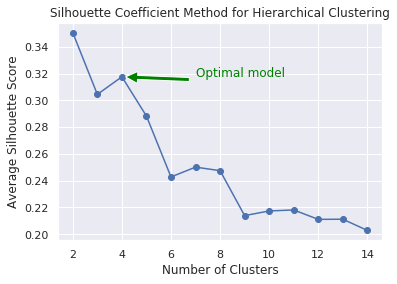

In [49]:
# Determine the optimal number of clusters by Silhouette Coefficient Method.
# (https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6)

k_ls = list(range(2,15))
score_ls = []
col = ['population_2020','density_p_km2','migrants_net','med_age','urban_pop_%','world_share_%','life_exp_both_sex','life_exp_female','life_exp_male',\
       'old_dep_ratio_2020','hospital_beds_per_100k','physicians_per_k','gdp_capita_usd','gross_publicdebt_pct_of_gdp','days_1st_case','days_1st_death']
X = country_master_df_t[col]

for k in k_ls:
    agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(X)
    score_ls += [silhouette_score(X, agg_clustering.labels_)]

# Assign optimal k    
score_s = pd.Series(score_ls)
abs_diff_s = score_s.diff().abs()
for i in range(len(k_ls))[::-1]:
    if i < range(len(k_ls))[-1] and score_s[i] == score_s[i:].max() and abs_diff_s[i] < abs_diff_s[i+1]:
        k = k_ls[i]    
    
plt.grid(True)    
plt.plot(k_ls, score_ls, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Coefficient Method for Hierarchical Clustering')
plt.annotate('Optimal model', xy=(k,score_ls[k_ls.index(k)]), xytext=(k+3,score_ls[k_ls.index(k)]), arrowprops={'shrink':0.05, 'facecolor':'green'}, color='green')
plt.subplots_adjust(left=0.15)

plt.savefig('Silhouette Coefficient Method for Hierarchical Clustering.png', dpi=200)

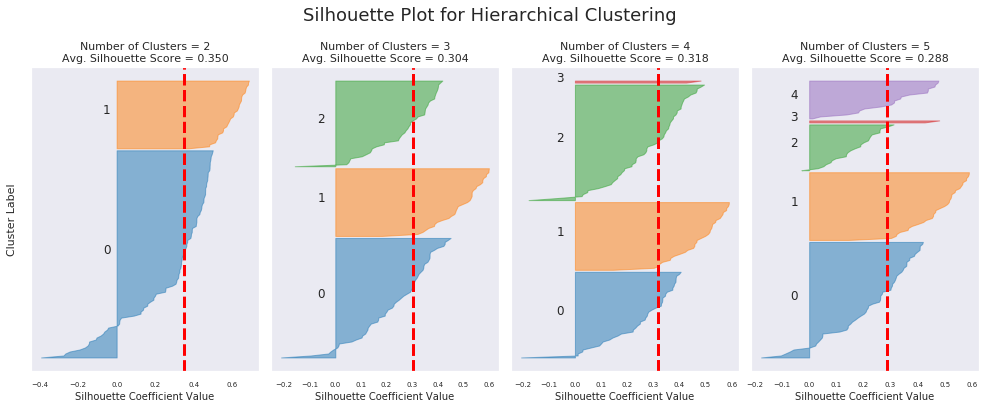

In [50]:
sample_ls = []
col = ['population_2020','density_p_km2','migrants_net','med_age','urban_pop_%','world_share_%','life_exp_both_sex','life_exp_female','life_exp_male',\
       'old_dep_ratio_2020','hospital_beds_per_100k','physicians_per_k','gdp_capita_usd','gross_publicdebt_pct_of_gdp','days_1st_case','days_1st_death']
X = country_master_df_t[col]
fig = plt.figure(figsize=[17,6])
color = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple', 'tab:olive']

for i in range(2,k+2):
    y_lower = 5
    agg_clustering = AgglomerativeClustering(n_clusters=i, linkage='ward').fit(X)
    score = silhouette_score(X, agg_clustering.labels_)
    sample_ls = silhouette_samples(X, agg_clustering.labels_)
    ax = plt.subplot(1, len(range(2,k+2)), i-1)
    ax.set_title(f'Number of Clusters = {i}\nAvg. Silhouette Score = {score:.3f}', fontsize=11)
    ax.set_xlabel('Silhouette Coefficient Value', fontsize=10)
    ax.set_ylabel('Cluster Label', fontsize=11) if i==2 else ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yticklabels([])
    
    for j in range(i):
        y_upper = y_lower + sample_ls[agg_clustering.labels_==j].shape[0]
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, sorted(sample_ls[agg_clustering.labels_==j]), facecolor=color[j], edgecolor=color[j], alpha=.5)
        y_lower = y_upper
        ax.axvline(score, ls='--', color='red', lw=3)
        ax.text(x=-0.07, y=y_lower-sample_ls[agg_clustering.labels_==j].shape[0]*.5, s=j)

plt.suptitle('Silhouette Plot for Hierarchical Clustering', fontsize=18, y=.97)
plt.subplots_adjust(wspace=0.05, top=.83)
plt.savefig('Silhouette Plot for Hierarchical Clustering.png', dpi=200)

In [51]:
# Run Hierarchical clustering algorithm on country_master_df_t to segment countries.

col = ['population_2020','density_p_km2','migrants_net','med_age','urban_pop_%','world_share_%','life_exp_both_sex','life_exp_female','life_exp_male',\
       'old_dep_ratio_2020','hospital_beds_per_100k','physicians_per_k','gdp_capita_usd','gross_publicdebt_pct_of_gdp','days_1st_case','days_1st_death']
X = country_master_df_t[col]
agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(X)

X.insert(loc=0, column='cluster', value=agg_clustering.labels_)

# Incorporate results of clusters and cluster distances into country_master_df1

df1 = country_master_df1.dropna(axis=0)
df2 = X.loc[:,'cluster'].apply(lambda x: int(x))

country_cluster_df1 = df1.join(df2, how='left')
col = country_cluster_df1.columns
country_cluster_df1 = country_cluster_df1[['cluster']+list(col)]
country_cluster_df1 = country_cluster_df1.iloc[:,:-1]

# Incorporate results of clusters and cluster distances into country_master_df_t

df3 = country_master_df_t.copy()

country_cluster_df_t = df3.join(df2, how='left')
col = country_cluster_df_t.columns
country_cluster_df_t = country_cluster_df_t[['cluster']+list(col)]
country_cluster_df_t = country_cluster_df_t.iloc[:,:-1]
country_cluster_df_t['cluster'] = country_cluster_df_t['cluster'].apply(lambda x: int(x))
col = country_cluster_df_t.columns
col = list(col[0:3]) + list(col[48:]) + ['R0'] + list(col[3:11]) + list(col[13:15]) + list(col[15:29]) + list(col[11:13]) + list(col[30:48])
country_cluster_df_t = country_cluster_df_t[col]

# Print clustering outcome
sort_metric = 'deaths_per_m'
print(f'The country with the highest "{sort_metric}" is in Cluster {int(country_cluster_df1.sort_values(sort_metric, ascending=False).head(1).cluster)}.')
print()
print('Cluster counts:')
print(pd.Series(agg_clustering.labels_).value_counts())
# Print role model country for each cluster
country_cluster_df1.sort_values(sort_metric, ascending=True).groupby('cluster').head(1).sort_values('cluster')

The country with the highest "deaths_per_m" is in Cluster 0.

Cluster counts:
2    59
0    44
1    35
3     2
dtype: int64


cluster   longitude   latitude  total_cases  total_deaths  \
country                                                              
Taiwan         0  120.992886  23.972586          441             7   
Laos           1  103.763406  18.502451           19             0   
Bhutan         2   90.429433  27.415461           27             0   
India          3   79.618818  22.881321       144069          4117   

         total_recovered  total_tests  active_cases  serious_critical  \
country                                                                 
Taiwan               415        70880            19                 0   
Laos                  14         5795             5                 0   
Bhutan                 6        15607            21                 0   
India              58727      3033591         81225              8944   

         cases_per_m  deaths_per_m  tests_per_m  tests_per_case  \
country                                                           
Taiwan          19.0           0.3       2977.0      160.725624   
Laos             3.0           0.0        798.0      305.000000   
Bhutan          35.0           0.0      20250.0      578.037037   
India          105.0           3.0       2200.0       21.056515   

         recovery_rate  critical_rate  population_2020  density_p_km2  \
country                                                                 
Taiwan       94.104308       0.000000     2.381678e+07          673.0   
Laos         73.684211       0.000000     7.275560e+06           32.0   
Bhutan       22.222222       0.000000     7.716080e+05           20.0   
India        40.763107      11.011388     1.380004e+09          464.0   

         migrants_net  med_age  urban_pop_%  world_share_%  life_exp_both_sex  \
country                                                                         
Taiwan        30001.0     42.0         79.0           0.31              81.04   
Laos         -14704.0     24.0         36.0           0.09              68.89   
Bhutan          320.0     28.0         46.0           0.01              72.77   
India       -532687.0     28.0         35.0          17.70              70.42   

         life_exp_female  life_exp_male  old_dep_ratio_2020  \
country                                                       
Taiwan             83.64          78.49           21.611415   
Laos               70.79          67.04            6.676481   
Bhutan             73.33          72.27            9.005052   
India              71.80          69.16            9.773047   

         hospital_beds_per_100k  physicians_per_k  gdp_capita_usd  \
country                                                             
Taiwan                  1.67521            11.182         24827.0   
Laos                    1.50000             0.491          2670.0   
Bhutan                  1.70000             0.381          3423.0   
India                   0.53000             0.758          2171.0   

         gross_publicdebt_pct_of_gdp        R0  c1_school_closing  c1_flag  \
country                                                                      
Taiwan                          29.9  0.000000                3.0      1.0   
Laos                            67.3  0.000000                3.0      1.0   
Bhutan                          93.7  6.000000                3.0      1.0   
India                           70.2  1.295198                3.0      1.0   

         c2_workplace_closing  c2_flag  c3_cancel_public_events  c3_flag  \
country                                                                    
Taiwan                    0.0      0.0                      1.0      1.0   
Laos                      3.0      1.0                      2.0      1.0   
Bhutan                    2.0      1.0                      1.0      1.0   
India                     3.0      1.0                      2.0      1.0   

         c4_restrictions_on_gatherings  c4_flag  c5_close_public_transport  \
country               

cluster   longitude   latitude  total_cases  total_deaths  \
country                                                              
China          3  103.893473  36.518701        82985          4634   
India          3   79.618818  22.881321       144069          4117   

         total_recovered  total_tests  active_cases  serious_critical  \
country                                                                 
China              78268            0            83                 7   
India              58727      3033591         81225              8944   

         cases_per_m  deaths_per_m  tests_per_m  tests_per_case  \
country                                                           
China           58.0           3.0          0.0        0.000000   
India          105.0           3.0       2200.0       21.056515   

         recovery_rate  critical_rate  
country                                
China        94.315840       8.433735  
India        40.763107      11.011388

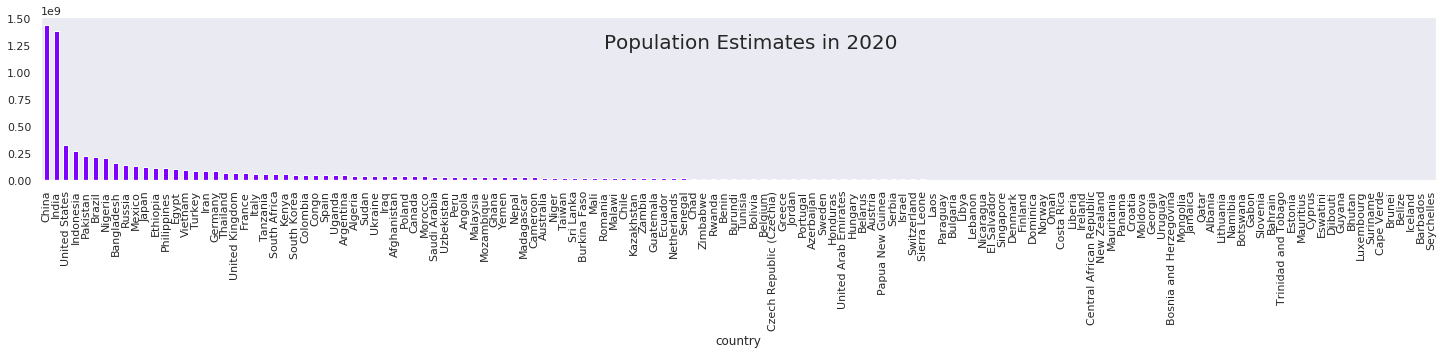

In [52]:
# Exploration the smallest cluster

cluster = country_cluster_df1.reset_index().groupby('cluster').count().country.sort_values().index[0]
country_cluster_df1.population_2020.sort_values(ascending=False).plot.bar(figsize=[25,3], colormap=cm.rainbow)
plt.text(x=country_cluster_df1.shape[0]*.4, y=country_cluster_df1.population_2020.max()*.85, s='Population Estimates in 2020', fontsize=20)
country_cluster_df1[country_cluster_df1.cluster==cluster].sort_values(sort_metric).iloc[:,:15]

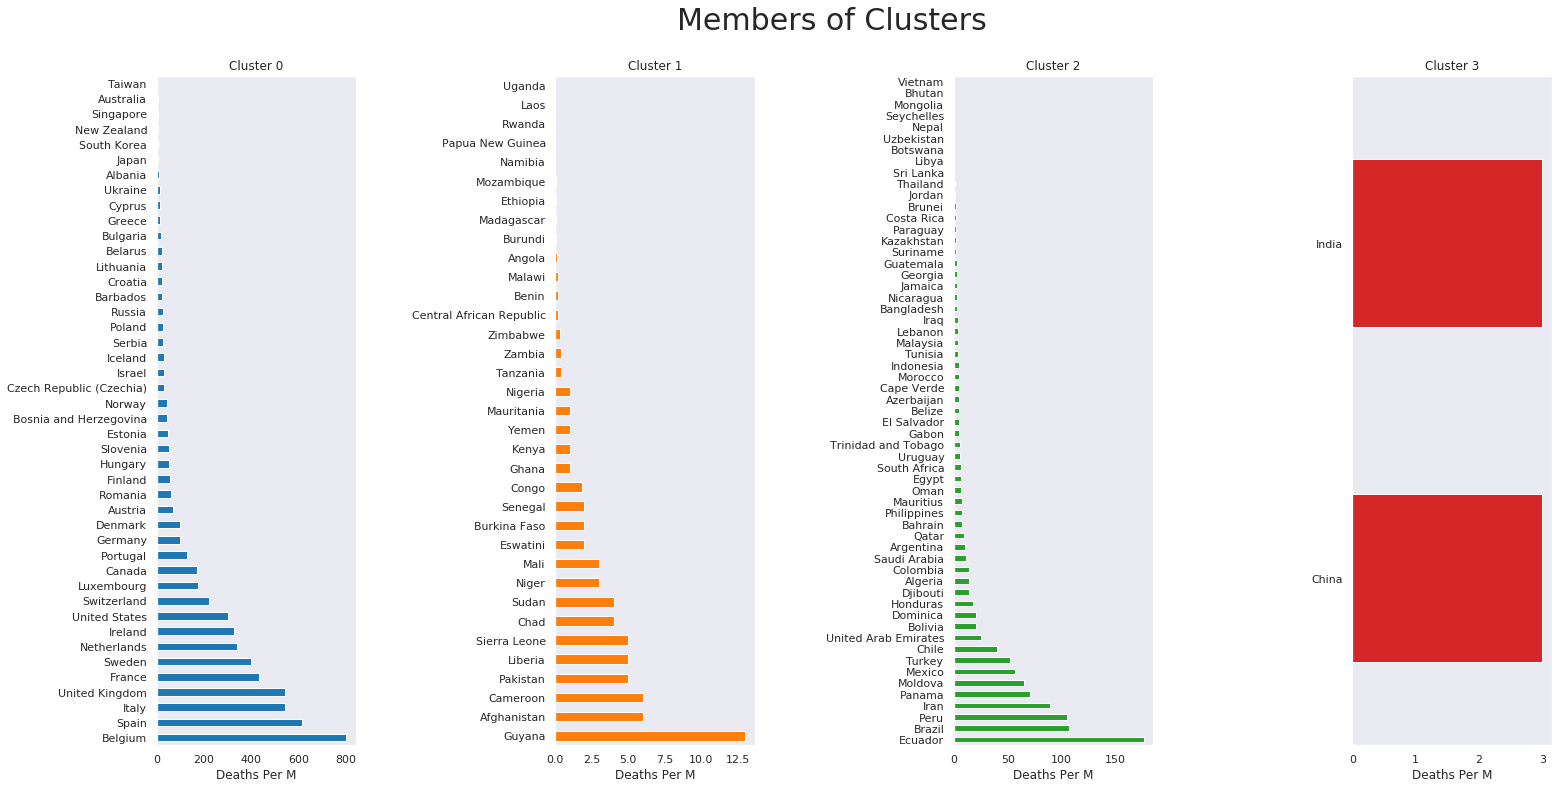

In [53]:
# Member countries in each cluster

fig = plt.figure(figsize=[25,12])
plt.subplots_adjust(wspace=1, top=0.9)
plt.suptitle('Members of Clusters', fontsize=30)
cluster_color = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
for c in country_cluster_df1.cluster.sort_values().unique():
    ax = plt.subplot(1,len(country_cluster_df1.cluster.sort_values().unique()),c+1)
    df = country_cluster_df1[country_cluster_df1.cluster==c][[sort_metric]].sort_values(sort_metric, ascending=False)
    df.plot.barh(title=f'Cluster {c}', legend=False, color=cluster_color[c], ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel(sort_metric.replace('_',' ').title())
plt.savefig('Members of Clusters.png', dpi=200)

cluster   longitude    latitude  days_1st_case  days_1st_death  \
count  140.000000  140.000000  140.000000     140.000000      140.000000   
mean     1.135714   19.313274   20.318867      11.746464       13.922175   
std      0.883182   57.850018   25.219555       5.744499        4.037055   
min      0.000000 -102.534991  -41.837107       0.000000        0.000000   
25%      0.000000   -3.555580    4.422787       7.722772       12.313433   
50%      1.000000   20.647056   19.381177      10.841584       14.104478   
75%      2.000000   46.912576   41.297073      13.069307       16.119403   
max      3.000000  171.603971   64.997650      30.000000       30.000000   

               R0  total_cases  total_deaths  total_recovered  total_tests  \
count  140.000000   140.000000    140.000000       140.000000   140.000000   
mean     3.617491     0.692769      0.745990         1.085059     1.010202   
std      3.804043     2.735549      3.036935         3.292073     3.183793   
min      0.000000     0.000000      0.000000         0.000000     0.000000   
25%      2.258763     0.011251      0.003018         0.014210     0.024625   
50%      3.092081     0.058511      0.018713         0.098638     0.152343   
75%      4.068917     0.336999      0.155888         0.482003     0.620750   
max     30.000000    30.000000     30.000000        30.000000    30.000000   

       active_cases  serious_critical  cases_per_m  deaths_per_m  \
count    140.000000        140.000000   140.000000    140.000000   
mean       0.483548          0.661616     2.085754      1.895434   
std        2.624918          3.135021     3.705119      4.661906   
min        0.000000          0.000000     0.000000      0.000000   
25%        0.002842          0.000000     0.101720      0.074627   
50%        0.019644          0.012256     0.490761      0.186567   
75%        0.145740          0.101547     2.902341      1.026119   
max       30.000000         30.000000    30.000000     30.000000   

       recovery_rate  critical_rate  population_2020  density_p_km2  \
count     140.000000     140.000000       140.000000     140.000000   
mean       16.086817       0.922413         1.103080       0.747602   
std         8.147050       3.182112         3.591079       2.647296   
min         0.000000       0.000000         0.000000       0.000000   
25%         9.605870       0.000000         0.100313       0.086166   
50%        15.856399       0.211882         0.245056       0.287219   
75%        23.299355       0.661706         0.816138       0.548857   
max        30.000000      30.000000        30.000000      30.000000   

       migrants_net     med_age  urban_pop_%  world_share_%  \
count    140.000000  140.000000   140.000000     140.000000   
mean      10.984669   14.564935    16.821429       1.104842   
std        2.613487    8.310855     7.469136       3.589901   
min        0.000000    0.000000     0.000000       0.000000   
25%       10.457414    7.272727    11.379310       0.097455   
50%       10.742521   14.545455    17.413793       0.243638   
75%       11.144321   22.727273    22.974138       0.820249   
max       30.000000   30.000000    30.000000      30.000000   

       life_exp_both_sex  life_exp_female  life_exp_male  old_dep_ratio_2020  \
count         140.000000       140.000000     140.000000          140.000000   
mean           19.274221        18.960443      19.328628            8.773291   
std             7.073984         7.047701       7.131124            6.743545   
min             0.000000         0.000000       0.000000            0.000000   
25%            14.207695        13.593304      14.415069            2.906096   
50%            20.502119        20.741035      19.907469            6.401600   
75%            24.299804        24.263726      24.990912           14.189088   
max            30.000000        30.000000      30.000000           30.000000   

       hospital_beds_per_100k  physicians_per_k  gdp_capita_usd  \
count        

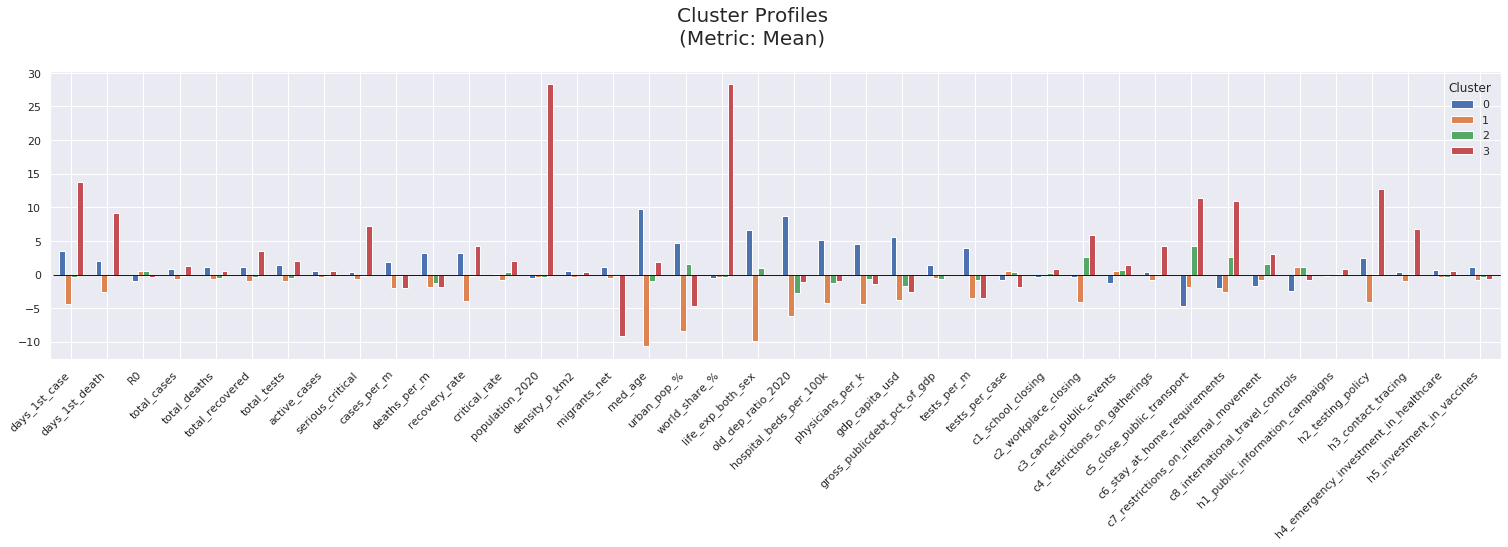

In [54]:
# Compare characteristics amongst clusters.

df = country_cluster_df_t.copy()
col = df.columns
rm_col_1 = ['latitude', 'longitude', 'stringencyindex', 'cluster', 'cluster_distance', 'life_exp_female', 'life_exp_male', 'm1_wildcard']
rm_col_2 = ['c1_flag', 'c2_flag', 'c3_flag', 'c4_flag', 'c5_flag', 'c6_flag', 'c7_flag', 'e1_flag', 'h1_flag']
rm_col_3 = ['c1_school_closing', 'c2_workplace_closing', 'c3_cancel_public_events', 'c4_restrictions_on_gatherings', 'c5_close_public_transport', \
            'c6_stay_at_home_requirements', 'c7_restrictions_on_internal_movement', 'c8_international_travel_controls']
rm_col_4 = ['e1_income_support', 'e2_debt/contract_relief', 'e3_fiscal_measures', 'e4_international_support']
rm_col_5 = ['h1_public_information_campaigns', 'h2_testing_policy', 'h3_contact_tracing', 'h4_emergency_investment_in_healthcare', 'h5_investment_in_vaccines']
rm_col = rm_col_1 + rm_col_2 + rm_col_4
col = [e for e in col if e not in rm_col]

overall_m = df[col].mean()

diff_df = pd.DataFrame(columns=list(range(0,len(df.cluster.unique()))))
for c in list(range(0,len(df.cluster.unique()))):
    cluster_m = df[df.cluster==c].loc[:,col].mean()
    diff_df.loc[:,c] = pd.Series(cluster_m - overall_m)

# Plot horizontal bar chart
sns.set(style='darkgrid')
diff_df.plot.bar(figsize=[len(diff_df.index)*0.65,10], width=0.65)
plt.hlines(0, xmin=-0.5, xmax=len(diff_df.index), ls='-', lw=1)
plt.xticks(rotation=45, ha='right')

plt.suptitle('Cluster Profiles\n(Metric: Mean)', fontsize=20, y=0.99)
plt.legend(title='Cluster', ncol=1, frameon=False)
plt.subplots_adjust(bottom=0.5, top=0.9)

plt.savefig('Cluster Profiles_Metric Mean.png', dpi=200)

df.describe()

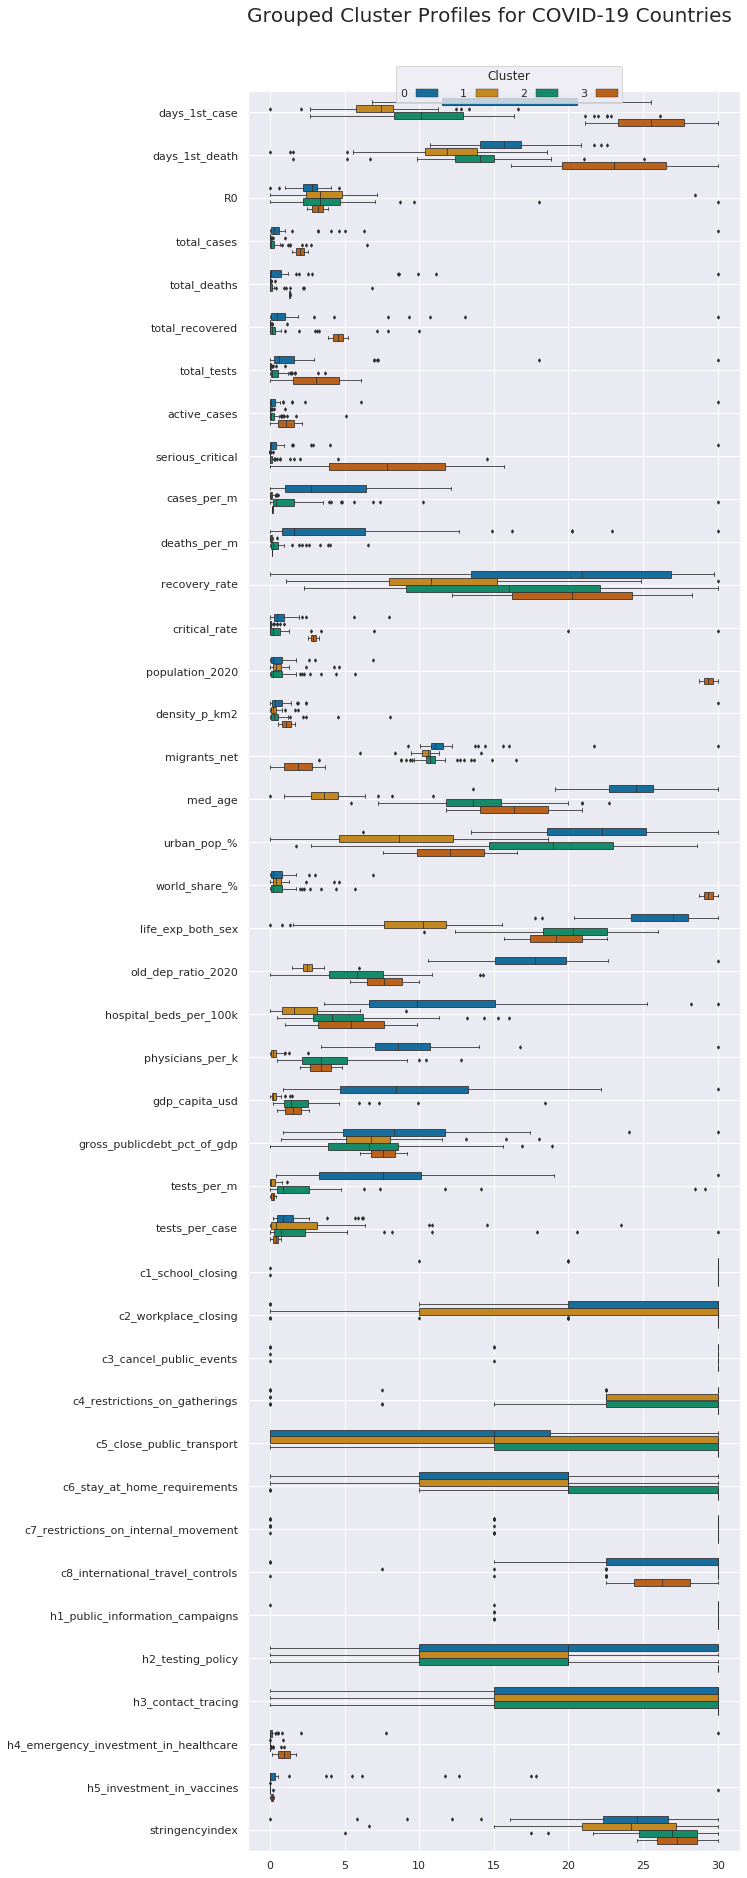

In [55]:
# Compare characteristics amongst clusters with boxplot to show distribution of each variable.

# Prepare df and columns for clustering profile boxplot
df = country_cluster_df_t.copy()
col = df.columns
rm_col_1 = ['latitude', 'longitude', 'cluster', 'life_exp_female', 'life_exp_male', 'm1_wildcard']
rm_col_2 = ['c1_flag', 'c2_flag', 'c3_flag', 'c4_flag', 'c5_flag', 'c6_flag', 'c7_flag', 'e1_flag', 'h1_flag']
rm_col_3 = ['c1_school_closing', 'c2_workplace_closing', 'c3_cancel_public_events', 'c4_restrictions_on_gatherings', 'c5_close_public_transport', 'c6_stay_at_home_requirements', \
            'c7_restrictions_on_internal_movement', 'c8_international_travel_controls']
rm_col_4 = ['e1_income_support', 'e2_debt/contract_relief', 'e3_fiscal_measures', 'e4_international_support']
rm_col_5 = ['h1_public_information_campaigns', 'h2_testing_policy', 'h3_contact_tracing', 'h4_emergency_investment_in_healthcare', 'h5_investment_in_vaccines']
rm_col = rm_col_1 + rm_col_2 + rm_col_4
col = [e for e in col if e not in rm_col]

# Reshape df into long form to plot
df4 = df.melt(id_vars='cluster', value_vars=col)
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=[12,30])

ax = plt.subplot()
sns.boxplot(data=df4, y='variable', x='value', hue='cluster', ax=ax, orient='h', width=0.65, palette=sns.color_palette('colorblind'), linewidth=0.8, fliersize=2.3)
ax.set(ylabel='', xlabel='')
ax.get_legend().remove()
fig.legend(loc=(0.53, 0.945), ncol=df.cluster.max()+1, title='Cluster', frameon=True, markerfirst=False)
plt.subplots_adjust(top=0.94, left=0.4, right=0.97)
plt.suptitle('Grouped Cluster Profiles for COVID-19 Countries', horizontalalignment='center', verticalalignment='bottom', fontsize=20, y=0.97, x=0.68)
plt.grid(True)
plt.savefig('Grouped Cluster Profiles for COVID-19 Countries.png', dpi=200)

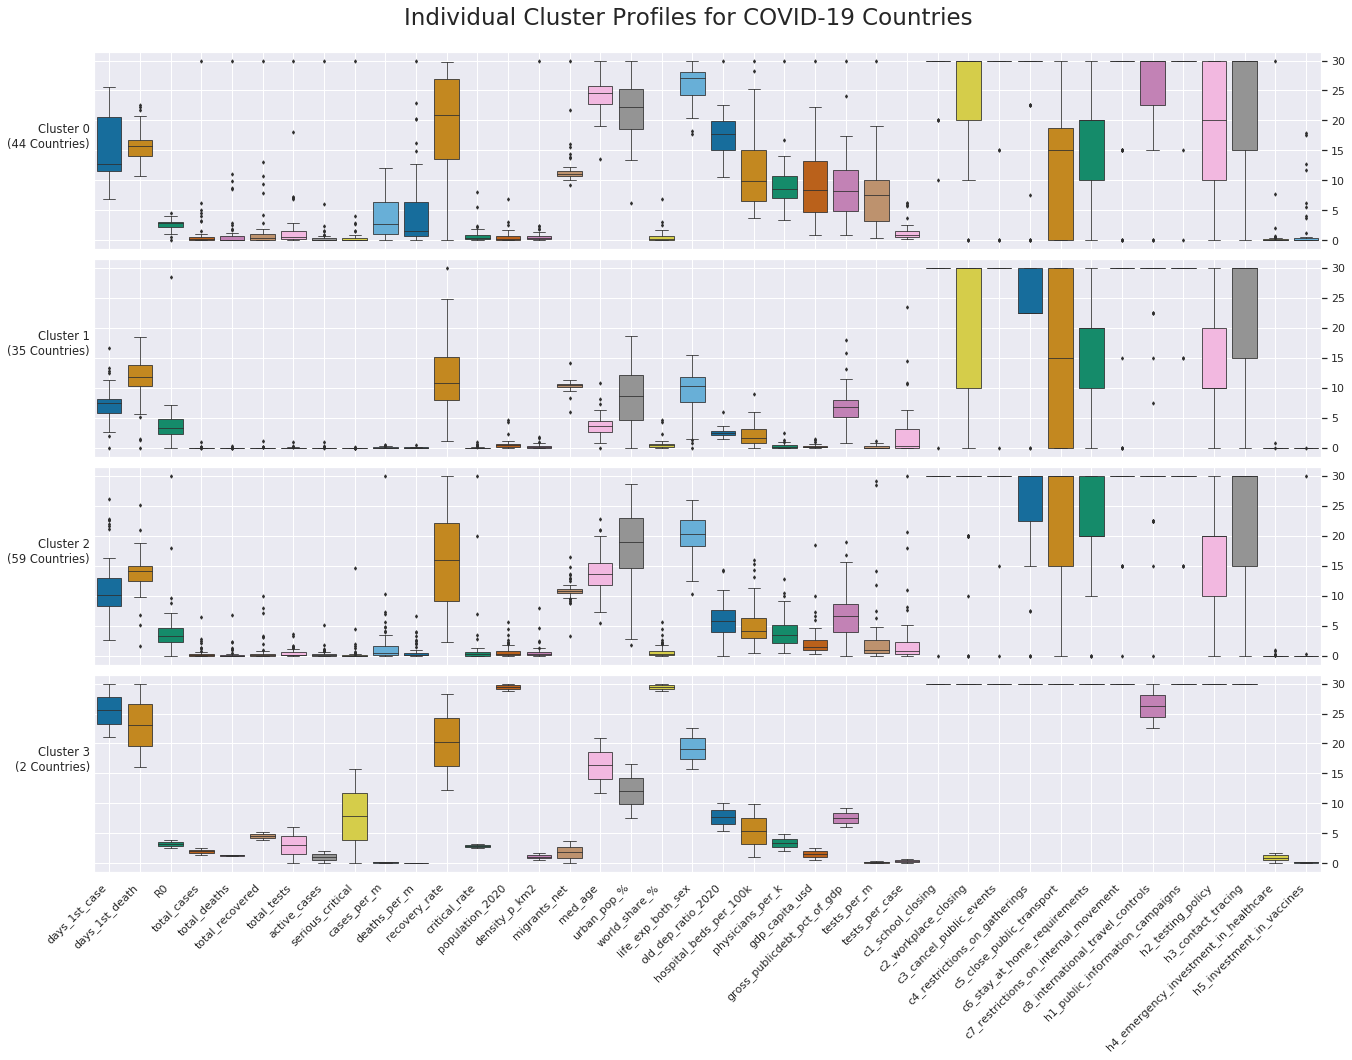

In [56]:
# Compare characteristics amongst clusters with boxplot to show distribution of each variable.

df = country_cluster_df_t.copy()
col = df.columns
rm_col_1 = ['latitude', 'longitude', 'stringencyindex', 'cluster', 'cluster_distance', 'life_exp_female', 'life_exp_male', 'm1_wildcard']
rm_col_2 = ['c1_flag', 'c2_flag', 'c3_flag', 'c4_flag', 'c5_flag', 'c6_flag', 'c7_flag', 'e1_flag', 'h1_flag']
rm_col_3 = ['c1_school_closing', 'c2_workplace_closing', 'c3_cancel_public_events', 'c4_restrictions_on_gatherings', 'c5_close_public_transport', 'c6_stay_at_home_requirements', \
            'c7_restrictions_on_internal_movement', 'c8_international_travel_controls']
rm_col_4 = ['e1_income_support', 'e2_debt/contract_relief', 'e3_fiscal_measures', 'e4_international_support']
rm_col_5 = ['h1_public_information_campaigns', 'h2_testing_policy', 'h3_contact_tracing', 'h4_emergency_investment_in_healthcare', 'h5_investment_in_vaccines']
rm_col = rm_col_1 + rm_col_2 + rm_col_4
col = [e for e in col if e not in rm_col]

sns.set(style='darkgrid')
fig, axes = plt.subplots(df.cluster.max()+1, 1, figsize=[22,15])

for cluster in df.cluster.unique():
    axes = plt.subplot(df.cluster.max()+1, 1, cluster+1)
    sns.boxplot(data=df[df.cluster==cluster][col], ax=axes, orient='v', palette=sns.color_palette('colorblind'), linewidth=0.8, fliersize=2.3)
    axes.yaxis.tick_right()
    axes.set_ylabel(f'Cluster {cluster}\n({df[df.cluster==cluster].count().drop_duplicates().cluster} Countries)', fontsize=11.5, rotation='horizontal', ha='right')
    axes.grid(True)
    if cluster != df.cluster.max(): 
        axes.set(xticklabels=[])
    else:
        axes.set_xticklabels(axes.get_xticklabels(), rotation=45, va='top', ha='right')

plt.subplots_adjust(hspace=0.05, top=.94, bottom=0.18)
plt.suptitle('Individual Cluster Profiles for COVID-19 Countries', horizontalalignment='center', verticalalignment='bottom', fontsize=23, y=0.96)
plt.savefig('Individual Cluster Profiles for COVID-19 Countries.png', dpi=200)

# Folium Map

In [57]:
df = country_cluster_df_t.copy()

# m = folium.Map(location=[0,0], tiles='Stamen Toner', zoom_start=2.1)
m = folium.Map(location=[0,0], tiles='cartodbpositron', zoom_start=2.1)
header = 'deaths_per_m'
# rainbow = cm.rainbow(np.linspace(0,1,len(df.cluster.unique())))
cluster_color = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

for i, cluster in enumerate(df.cluster):
    
    row = df.iloc[i]
    value = country_cluster_df1.loc[row.name][header]
    lat = row.latitude.astype('float')
    lon = row.longitude.astype('float')
    measurement = row[header]
    label = '{} / Cluster {:.0f} : {:,.2f}'.format(row.name, cluster, value)
    popup = folium.Popup(label, parse_html=True)
    
    if measurement > 0:
        folium.CircleMarker(
            location=[lat,lon],
            popup=popup,
            radius=measurement+1.5,
            fill=True,
            color=colors.to_hex(cluster_color[cluster]),
            fill_color=colors.to_hex(cluster_color[cluster]),
            fill_opacity=.5,
            parse_html=True).add_to(m)

title_html = '''
             <h1 align="center" style="font-size:20px"><b>Clustering Map for COVID-19 Deaths Per Million Population</b></h1>
             '''
m.get_root().html.add_child(folium.Element(title_html))        
    
print('{}'.format(header.replace('_',' ').title()))
m

Deaths Per M


In [58]:
country_cluster_df1[country_cluster_df1.index=='Belgium']

cluster  longitude   latitude  total_cases  total_deaths  \
country                                                             
Belgium        0   4.664348  50.642952        57342          9312   

         total_recovered  total_tests  active_cases  serious_critical  \
country                                                                 
Belgium            15297       788110         32733               251   

         cases_per_m  deaths_per_m  tests_per_m  tests_per_case  \
country                                                           
Belgium       4950.0         804.0      68031.0       13.744027   

         recovery_rate  critical_rate  population_2020  density_p_km2  \
country                                                                 
Belgium      26.676781        0.76681       11589623.0          383.0   

         migrants_net  med_age  urban_pop_%  world_share_%  life_exp_both_sex  \
country                                                                         
Belgium       48000.0     42.0         98.0           0.15              82.17   

         life_exp_female  life_exp_male  old_dep_ratio_2020  \
country                                                       
Belgium            84.31           80.0           30.220853   

         hospital_beds_per_100k  physicians_per_k  gdp_capita_usd  \
country                                                             
Belgium                    5.64             3.011         45175.0   

         gross_publicdebt_pct_of_gdp        R0  c1_school_closing  c1_flag  \
country                                                                      
Belgium                        104.3  0.865602                2.0      1.0   

         c2_workplace_closing  c2_flag  c3_cancel_public_events  c3_flag  \
country                                                                    
Belgium                   3.0      1.0                      2.0      1.0   

         c4_restrictions_on_gatherings  c4_flag  c5_close_public_transport  \
country                                                                      
Belgium                            4.0      1.0                        1.0   

         c5_flag  c6_stay_at_home_requirements  c6_flag  \
country                                                   
Belgium      1.0                           2.0      1.0   

         c7_restrictions_on_internal_movement  c7_flag  \
country                                                  
Belgium                                   2.0      1.0   

         c8_international_travel_controls  e1_income_support  e1_flag  \
country                                                                 
Belgium                               4.0                2.0      0.0   

         e2_debt/contract_relief  e3_fiscal_measures  \
country                                                
Belgium                      2.0        9.608192e+09   

         e4_international_support  h1_public_information_campaigns  h1_flag  \
country                                                                       
Belgium                       0.0                              2.0      1.0   

         h2_testing_policy  h3_contact_tracing  \
country                                          
Belgium                3.0                 2.0   

         h4_emergency_investment_in_healthcare  h5_investment_in_vaccines  \
country                                                                     
Belgium                           1.076350e+09                  5427500.0   

         m1_wildcard  stringencyindex  days_1st_case  days_1st_death  
country                                                               
Belgium          0.0            81.48          111.0            74.0

In [59]:
df = country_cluster_df1.copy()

# m = folium.Map(location=[0,0], tiles='Stamen Toner', zoom_start=2.1)
m = folium.Map(location=[0,0], tiles='cartodbpositron', zoom_start=2.1)
header = 'R0'
# rainbow = cm.rainbow(np.linspace(0,1,len(df.cluster.unique())))
cluster_color = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

for i, cluster in enumerate(df.cluster):
    
    row = df.iloc[i]
    value = country_cluster_df1.loc[row.name][header]
    lat = row.latitude.astype('float')
    lon = row.longitude.astype('float')
    measurement = row[header]
    label = '{} / Cluster {:.0f} : {:,.2f}'.format(row.name, cluster, value)
    popup = folium.Popup(label, parse_html=True)
    
    if measurement > 0:
        folium.CircleMarker(
            location=[lat,lon],
            popup=popup,
            radius=measurement*3,
            fill=True,
            color=colors.to_hex(cluster_color[cluster]),
            fill_color=colors.to_hex(cluster_color[cluster]),
            fill_opacity=.5,
            parse_html=True).add_to(m)

title_html = '''
             <h1 align="center" style="font-size:20px"><b>Clustering Map for COVID-19 Reproduction Number</b></h1>
             '''
m.get_root().html.add_child(folium.Element(title_html))        
    
print('{}'.format(header.replace('_',' ').title()))
m

R0


# Variable Correlation Exploration

2020-05-25 16:02:34.791405
0:23:23.880076


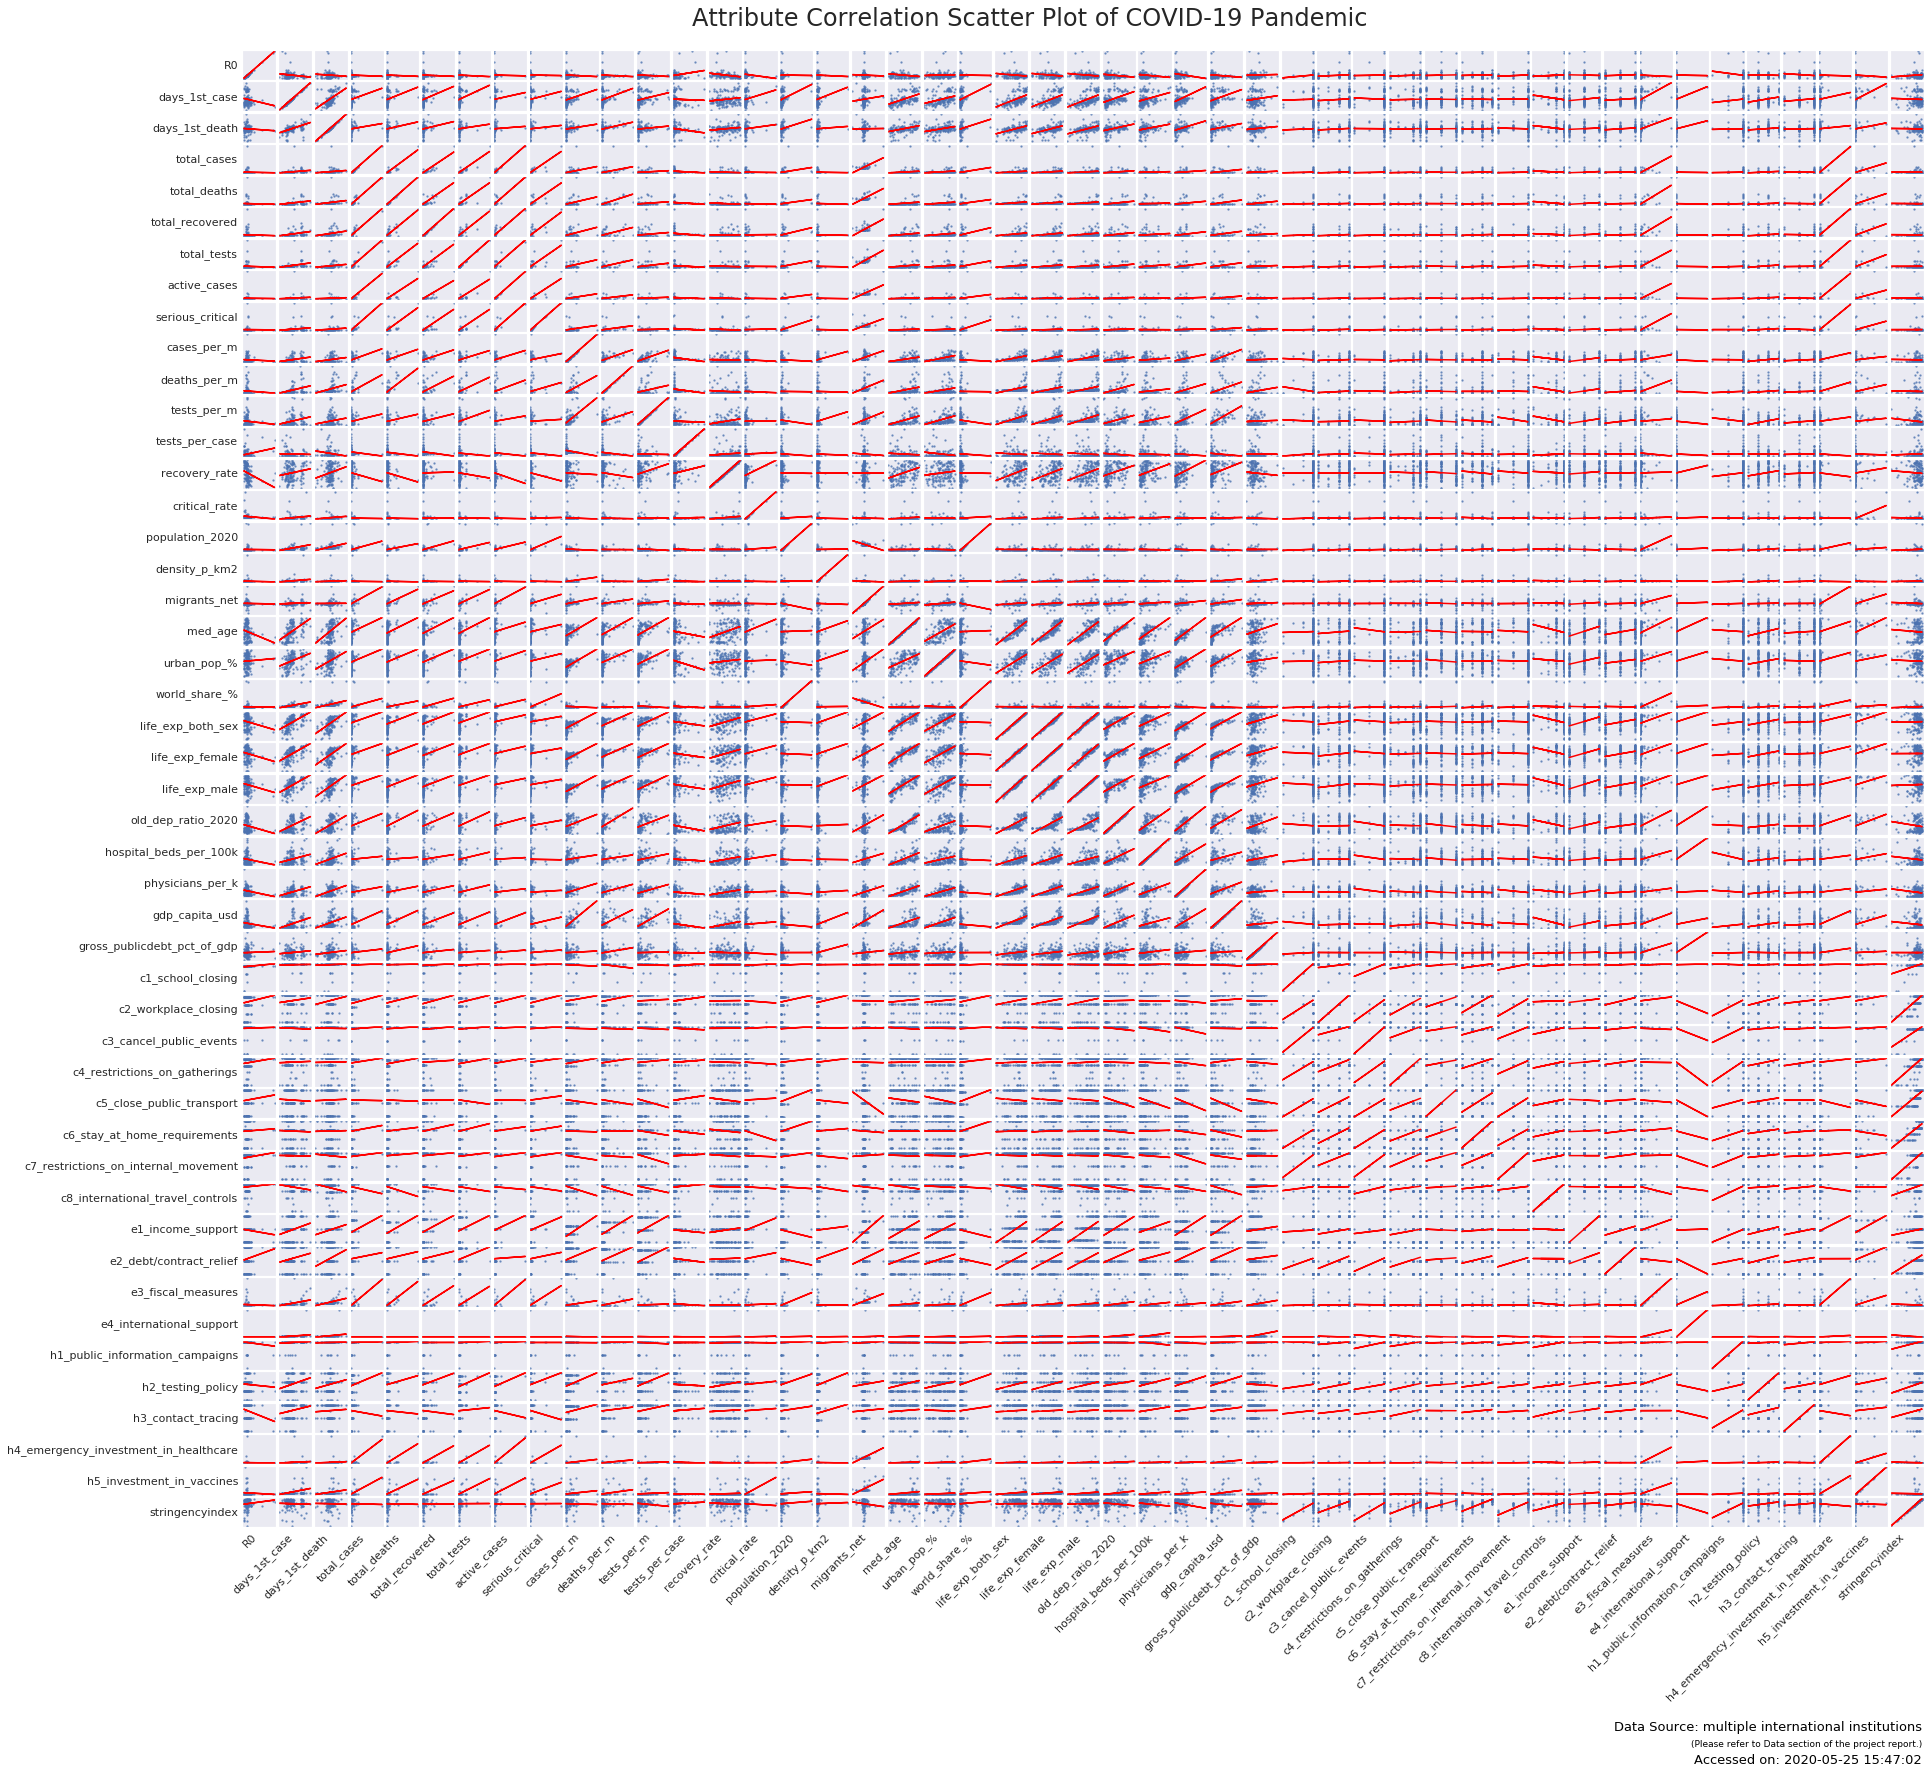

In [60]:
# Explore correlations for all measurements with scatter plot grid.

start=datetime.now()
print(start)

col_ls = ['R0','days_1st_case','days_1st_death','total_cases','total_deaths','total_recovered','total_tests','active_cases','serious_critical','cases_per_m','deaths_per_m',\
          'tests_per_m','tests_per_case','recovery_rate','critical_rate','population_2020','density_p_km2','migrants_net','med_age','urban_pop_%','world_share_%',\
          'life_exp_both_sex','life_exp_female','life_exp_male','old_dep_ratio_2020','hospital_beds_per_100k','physicians_per_k','gdp_capita_usd',\
          'gross_publicdebt_pct_of_gdp','c1_school_closing','c2_workplace_closing','c3_cancel_public_events','c4_restrictions_on_gatherings','c5_close_public_transport',\
          'c6_stay_at_home_requirements','c7_restrictions_on_internal_movement','c8_international_travel_controls','e1_income_support','e2_debt/contract_relief',\
          'e3_fiscal_measures','e4_international_support','h1_public_information_campaigns','h2_testing_policy','h3_contact_tracing','h4_emergency_investment_in_healthcare',\
          'h5_investment_in_vaccines','stringencyindex']

df = country_cluster_df1.copy()
xlabels = col_ls
ylabels = col_ls
col_n = len(col_ls)

sns.set(style='darkgrid')
fig, axes = plt.subplots(figsize=[27,27], ncols=len(xlabels), nrows=len(ylabels))

for a, x in enumerate(xlabels):
    for b, y in enumerate(ylabels):
        c,e = np.polyfit(x=df[x], y=df[y], deg=1)
        yhat = df[x] * c + e
        axes[b,a].scatter(x=df[x], y=df[y], s=2, alpha=.6)
        axes[b,a].plot(df[x], yhat, '-', color='red')
        if b==len(ylabels)-1:
            axes[b,a].set_xlabel(x, fontsize=11, rotation=45, va='top', ha='right') 
        if a==0:
            axes[b,a].set_ylabel(y, fontsize=11, rotation='horizontal', va='center', ha='right') 
        axes[b,a].set_xticks([])
        axes[b,a].set_yticks([])

fig.tight_layout()
plt.subplots_adjust(wspace=.05, hspace=.05, top=.96, right=0.99, bottom=0.2)
plt.suptitle('Attribute Correlation Scatter Plot of COVID-19 Pandemic', verticalalignment='bottom', fontsize=24, y=0.97, x=0.53)

# Add data source to the bottom        
t = str(start_time)[:str(datetime.now()).find('.')]
institute = 'multiple international institutions'
url = 'Please refer to Data section of the project report.'
plt.text(x=100, y=-750, s=f'Data Source: {institute}', color='Black', fontsize=13, ha='right')
plt.text(x=100, y=-750-60, s=f'({url})', color='Black', fontsize=9, ha='right')
plt.text(x=100, y=-750-120, s=f'Accessed on: {t}', color='Black', fontsize=13, ha='right')

plt.savefig('Attribute Correlation Scatter Plot of COVID19 Pandemic.png', dpi=200)
print(datetime.now()-start)

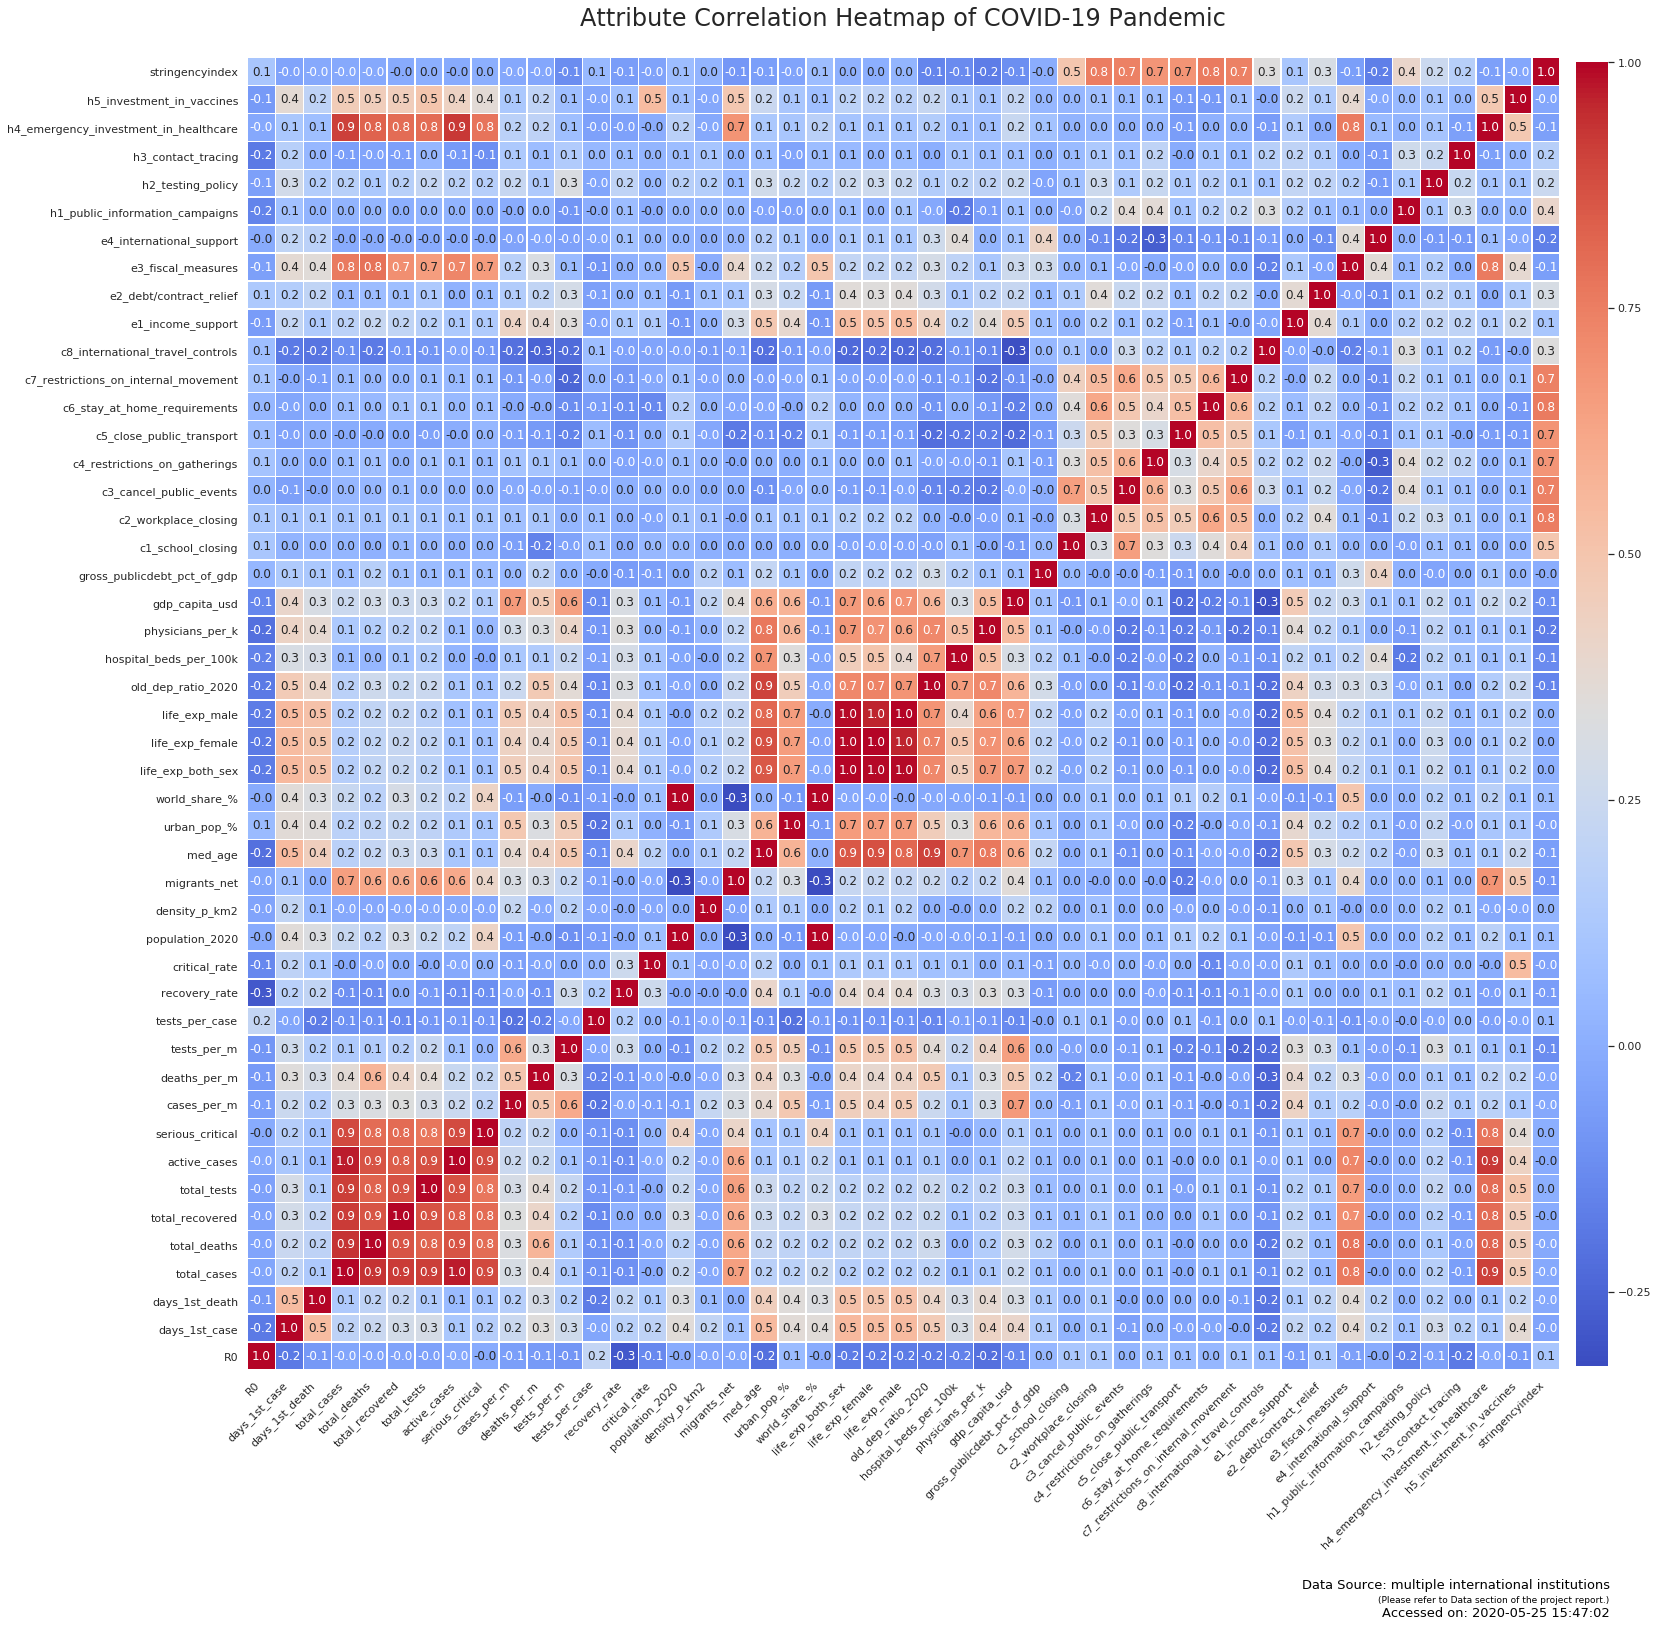

In [61]:
# Explore correlations between measurements with heatmap.

col_ls = ['R0','days_1st_case','days_1st_death', 'total_cases','total_deaths','total_recovered','total_tests','active_cases','serious_critical','cases_per_m',\
          'deaths_per_m','tests_per_m','tests_per_case','recovery_rate','critical_rate','population_2020','density_p_km2','migrants_net','med_age','urban_pop_%',\
          'world_share_%','life_exp_both_sex','life_exp_female','life_exp_male','old_dep_ratio_2020','hospital_beds_per_100k','physicians_per_k','gdp_capita_usd',\
          'gross_publicdebt_pct_of_gdp','c1_school_closing','c2_workplace_closing','c3_cancel_public_events','c4_restrictions_on_gatherings','c5_close_public_transport',\
          'c6_stay_at_home_requirements','c7_restrictions_on_internal_movement','c8_international_travel_controls','e1_income_support','e2_debt/contract_relief',\
          'e3_fiscal_measures','e4_international_support','h1_public_information_campaigns','h2_testing_policy','h3_contact_tracing','h4_emergency_investment_in_healthcare',\
          'h5_investment_in_vaccines','stringencyindex']

df = country_cluster_df1.copy()
# df = country_cluster_df_t.copy()
corr_df = df[col_ls].corr(method='pearson')
fig, ax = plt.subplots(figsize=[28,23])
ax = sns.heatmap(corr_df, annot=True, fmt='.1f', square=True, cmap='coolwarm', linewidths=.5, ax=ax, cbar_kws={'shrink': 0.91, 'orientation': 'vertical', 'aspect':40, 'pad': 0.01})
ax.set_ylim(0, len(col_ls))
ax.set_xticklabels(col_ls, rotation=45, va='top', ha='right')
plt.subplots_adjust(top=0.99)
plt.suptitle('Attribute Correlation Heatmap of COVID-19 Pandemic', verticalalignment='bottom', fontsize=24, y=0.97, x=0.45)

# Add data source to the bottom        
x = float(np.array(ax.get_position())[1][0])+48
y = float(np.array(ax.get_position())[0][1])-8
t = str(start_time)[:str(datetime.now()).find('.')]
institute = 'multiple international institutions'
url = 'Please refer to Data section of the project report.'
plt.text(x=x, y=y, s=f'Data Source: {institute}', color='Black', fontsize=13, ha='right')
plt.text(x=x, y=y-.5, s=f'({url})', color='Black', fontsize=9, ha='right')
plt.text(x=x, y=y-1, s=f'Accessed on: {t}', color='Black', fontsize=13, ha='right')

plt.savefig('Attribute Correlation Heatmap of COVID19 Pandemic.png', dpi=200)

0:01:05.818132


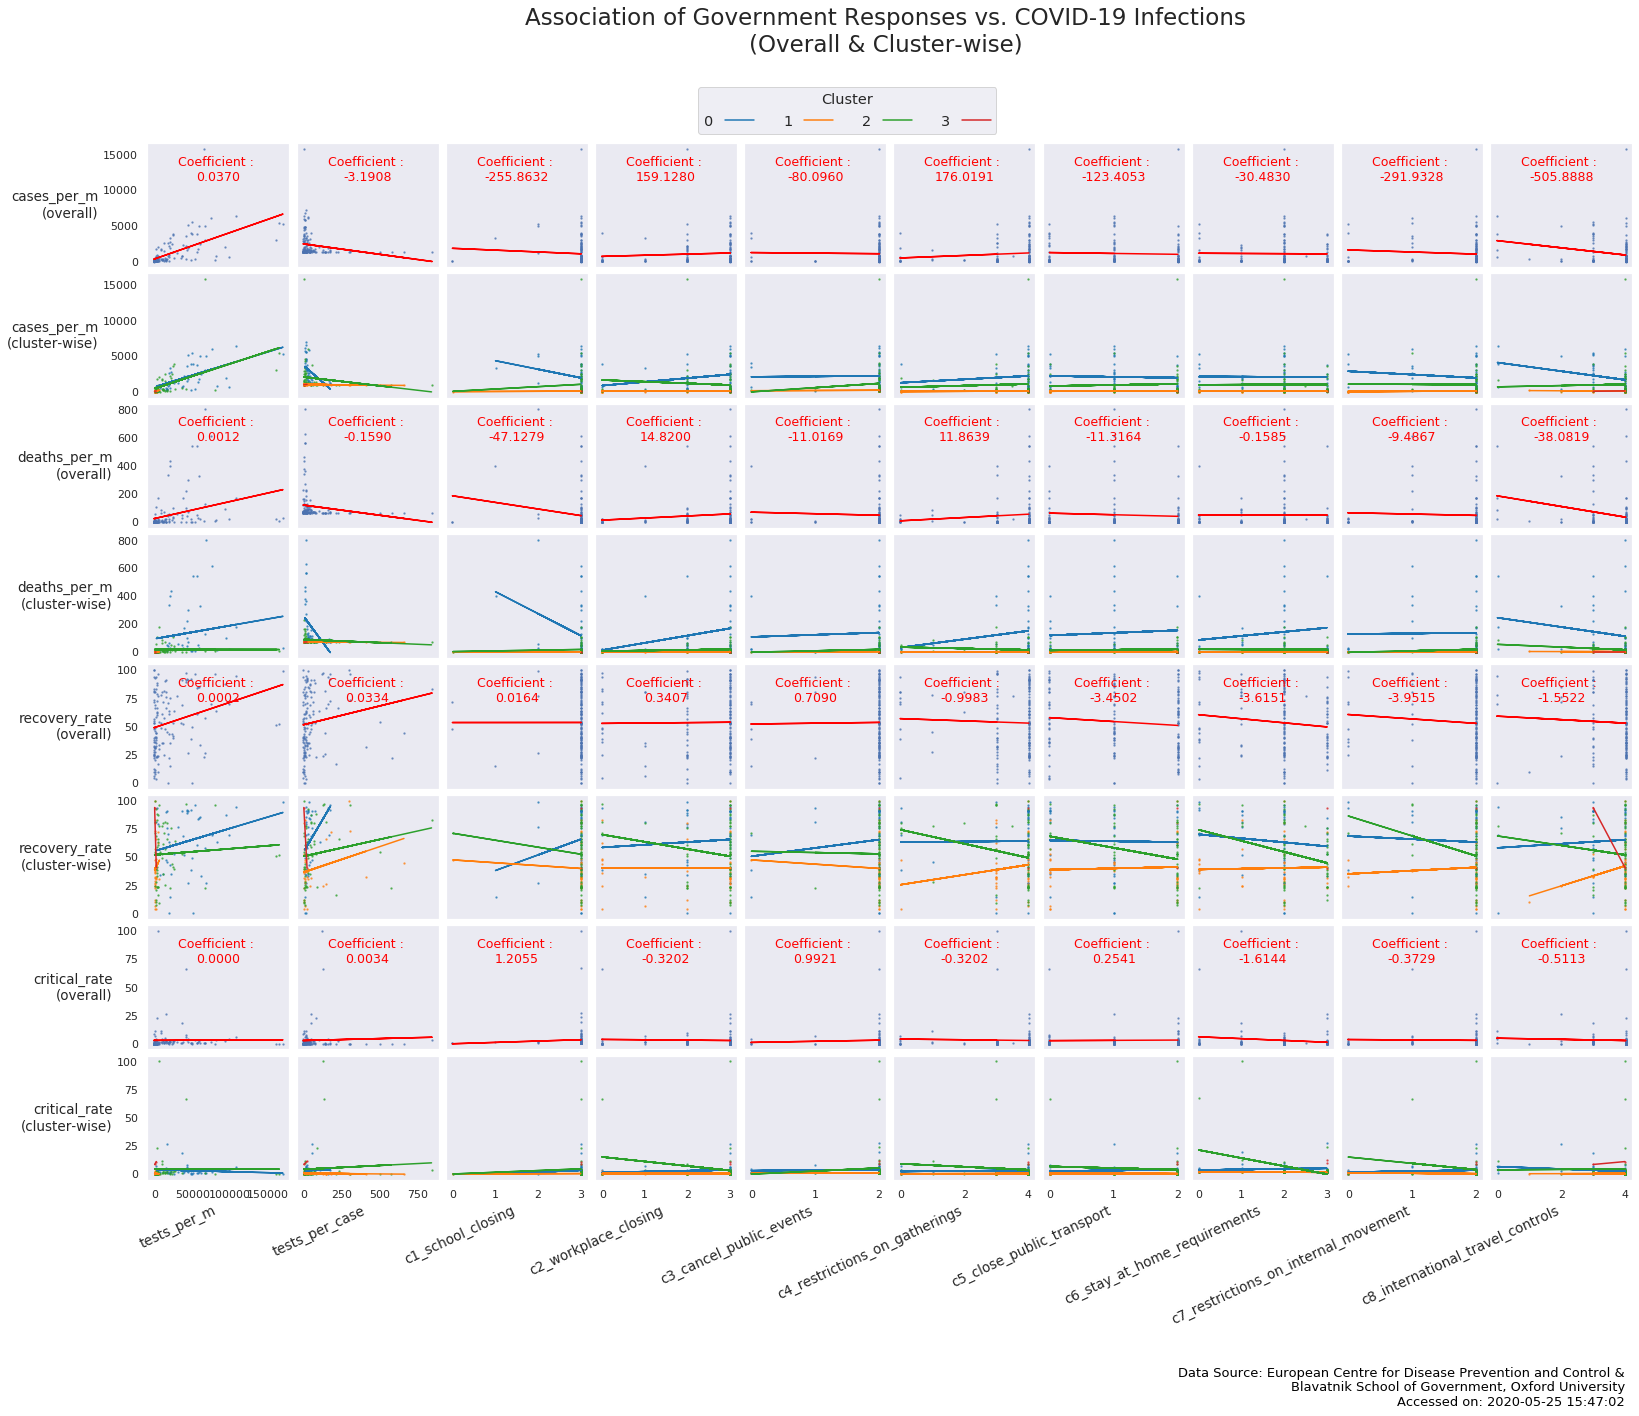

In [62]:
# Explore correlations of various containment measures against impacts of COVID-19 with scatter plot grid.

start = datetime.now()
warnings.filterwarnings('ignore')

col_ls = ['R0','total_cases','total_deaths','total_recovered','total_tests','active_cases','serious_critical','cases_per_m','deaths_per_m','tests_per_m','tests_per_case',\
          'recovery_rate','critical_rate','population_2020','density_p_km2','migrants_net','med_age','urban_pop_%','world_share_%','life_exp_both_sex','life_exp_female',\
          'life_exp_male','old_dep_ratio_2020','hospital_beds_per_100k','physicians_per_k','gdp_capita_usd','gross_publicdebt_pct_of_gdp','days_1st_case','days_1st_death',\
          'c1_school_closing','c2_workplace_closing','c3_cancel_public_events','c4_restrictions_on_gatherings','c5_close_public_transport','c6_stay_at_home_requirements',\
          'c7_restrictions_on_internal_movement','c8_international_travel_controls','e1_income_support','e2_debt/contract_relief','e3_fiscal_measures',\
          'e4_international_support','h1_public_information_campaigns','h2_testing_policy','h3_contact_tracing','h4_emergency_investment_in_healthcare',\
          'h5_investment_in_vaccines','stringencyindex']

df = country_cluster_df1.copy()
# df = country_cluster_df_t.copy()
xlabels = col_ls[9:11] + col_ls[29:37]
ylabels = col_ls[7:9] + col_ls[11:13]
cluster_color = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

sns.set(style='dark')
fig, axes = plt.subplots(figsize=[25,12*2], ncols=len(xlabels), nrows=len(ylabels)*2)

for a, x in enumerate(xlabels):
    for b, y in enumerate(ylabels):
        
# Overall plot
        c,e = np.polyfit(x=df[x], y=df[y], deg=1)
        yhat = df[x] * c + e
        
        axes[2*b,a].scatter(x=df[x], y=df[y], s=2, alpha=.6)
        axes[2*b,a].plot(df[x], yhat, '-', color='red')
        axes[2*b,a].annotate('Coefficient : \n{:.4f}'.format(c), xy=(0.5,0.9), xycoords='axes fraction', fontsize=12.5, color='red', ha='center', va='top')
        axes[2*b,a].grid(False)
        axes[2*b,a].set_xticks([])
        axes[2*b,a].set_xlabel('')

        if a==0:
            axes[2*b,a].set_ylabel(f'{y}\n(overall)', rotation='horizontal', va='center', ha='right', fontsize=13.5)
        if a!=0:
            axes[2*b,a].set_yticks([])     

# Cluster-wise plot
        for cluster in sorted(df.cluster.unique()):
            
            c,e = np.polyfit(x=df[df.cluster==cluster][x], y=df[df.cluster==cluster][y], deg=1)
            yhat = df[df.cluster==cluster][x] * c + e
            axes[2*b+1,a].scatter(x=df[df.cluster==cluster][x], y=df[df.cluster==cluster][y], s=2, alpha=.6, color=cluster_color[cluster])
            axes[2*b+1,a].plot(df[df.cluster==cluster][x], yhat, '-', label=cluster, color=cluster_color[cluster])
            axes[2*b+1,a].grid(False)

        if a==0:
            axes[2*b+1,a].set_ylabel(f'{y}\n(cluster-wise)', rotation='horizontal', va='center', ha='right', fontsize=13.5)
        if b==len(ylabels)-1:
            axes[2*b+1,a].set_xlabel(x, rotation=25, va='top', ha='right', fontsize=13.5) 
        if a!=0:
            axes[2*b+1,a].set_yticks([])
        if b!=len(ylabels)-1:
            axes[2*b+1,a].set_xticks([])
        
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.426,0.905), title_fontsize=14.5, fontsize=14.5, markerfirst=False, title='Cluster', frameon=True, ncol=df.cluster.max()+1)
plt.suptitle('Association of Government Responses vs. COVID-19 Infections\n(Overall & Cluster-wise)',verticalalignment='bottom', fontsize=23, y=0.95, x=0.535)
plt.subplots_adjust(top=.9, bottom=0.3, right=.95,  wspace=.05, hspace=.05)

# Add data source to the bottom        
t = str(start_time)[:str(datetime.now()).find('.')]
institute1 = 'European Centre for Disease Prevention and Control'
institute2 = 'Blavatnik School of Government, Oxford University'
plt.text(x=4, y=-180, s=f'Data Source: {institute1} &', color='Black', fontsize=13, ha='right')
plt.text(x=4, y=-180-13, s=f'{institute2}', color='Black', fontsize=13, ha='right')
plt.text(x=4, y=-180-26, s=f'Accessed on: {t}', color='Black', fontsize=13, ha='right')

plt.savefig('Association of Government Responses vs Infections.png', dpi=200)
print(datetime.now()-start)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16273 entries, 51 to 27852
Data columns (total 40 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   country                                16273 non-null  object        
 1   date_reported                          16273 non-null  datetime64[ns]
 2   day_reported                           16273 non-null  int64         
 3   month_reported                         16273 non-null  int64         
 4   year_reported                          16273 non-null  int64         
 5   covid_cases                            16273 non-null  int64         
 6   covid_deaths                           16273 non-null  int64         
 7   first_case_date                        16273 non-null  datetime64[ns]
 8   first_death_date                       16273 non-null  datetime64[ns]
 9   days_1st_case                          16273 non-null  int64

day_reported  month_reported  year_reported   covid_cases  \
count  16273.000000    16273.000000        16273.0  16273.000000   
mean      15.670313        3.862840         2020.0    330.253057   
std        8.496595        1.039411            0.0   1866.642022   
min        1.000000        1.000000         2020.0      0.000000   
25%        8.000000        3.000000         2020.0      0.000000   
50%       16.000000        4.000000         2020.0      6.000000   
75%       23.000000        5.000000         2020.0     69.000000   
max       31.000000        5.000000         2020.0  48529.000000   

       covid_deaths  days_1st_case  days_1st_death            R0  \
count  16273.000000   16273.000000    16273.000000  16273.000000   
mean      21.129970      41.116696       25.152277      1.747857   
std      134.784046      31.097135       23.389837      4.573224   
min        0.000000     -72.000000        0.000000      0.000000   
25%        0.000000      21.000000        0.000000      0.435897   
50%        0.000000      41.000000       21.000000      1.000000   
75%        2.000000      61.000000       43.000000      1.687135   
max     4928.000000     146.000000      135.000000    190.000000   

       c1_school_closing       c1_flag  c2_workplace_closing       c2_flag  \
count       16273.000000  16273.000000          16273.000000  16273.000000   
mean            1.934739      0.622196              1.364346      0.488601   
std             1.399156      0.484853              1.271492      0.499885   
min             0.000000      0.000000              0.000000      0.000000   
25%             0.000000      0.000000              0.000000      0.000000   
50%             3.000000      1.000000              2.000000      0.000000   
75%             3.000000      1.000000              3.000000      1.000000   
max             3.000000      1.000000              3.000000      1.000000   

       c3_cancel_public_events       c3_flag  c4_restrictions_on_gatherings  \
count             16273.000000  16273.000000                   16273.000000   
mean                  1.293738      0.606772                       2.089781   
std                   0.935018      0.488482                       1.802295   
min                   0.000000      0.000000                       0.000000   
25%                   0.000000      0.000000                       0.000000   
50%                   2.000000      1.000000                       3.000000   
75%                   2.000000      1.000000                       4.000000   
max                   2.000000      1.000000                       4.000000   

            c4_flag  c5_close_public_transport       c5_flag  \
count  16273.000000               16273.000000  16273.000000   
mean       0.547717                   0.689055      0.360290   
std        0.497733                   0.835198      0.480099   
min        0.000000                   0.000000      0.000000   
25%        0.000000                   0.000000      0.000000   
50%        1.000000                   0.000000      0.000000   
75%        1.000000                   1.000000      1.000000   
max        1.000000                   2.000000      1.000000   

       c6_stay_at_home_requirements       c6_flag  \
count                  16273.000000  16273.000000   
mean                       1.022983      0.441345   
std                        1.064807      0.496563   
min                        0.000000      0.000000   
25%                        0.000000      0.000000   
50%                        1.000000      0.000000   
75%                        2.000000      1.000000   
max                        3.000000      1.000000   

       c7_restrictions_on_internal_movement       c7_flag  \
count                          16273.000000  16273.000000   
mean                               1.013581      0.414367   
std                                0.945283      0.492628   
min                                0.000000      0.000000   
25%   

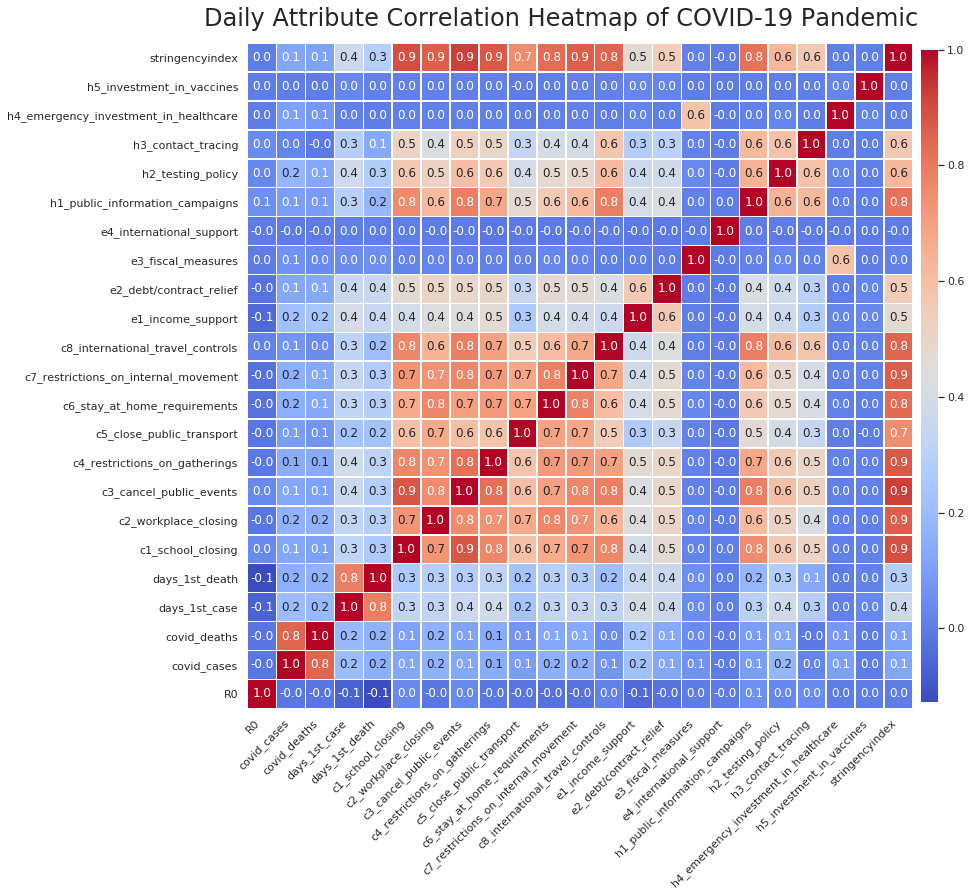

In [63]:
df = daily_covid_govresponse_df.copy()
df = df[df.R0.notna()]
df.info()

col_ls = list(df.columns)
rm_col_1 = ['country', 'date_reported', 'day_reported', 'month_reported', 'year_reported', 'first_case_date', 'first_death_date']
rm_col_2 = ['c1_flag', 'c2_flag', 'c3_flag', 'c4_flag', 'c5_flag', 'c6_flag', 'c7_flag', 'e1_flag', 'h1_flag', 'm1_wildcard']
rm_col_3 = ['c1_school_closing', 'c2_workplace_closing', 'c3_cancel_public_events', 'c4_restrictions_on_gatherings', 'c5_close_public_transport', \
            'c6_stay_at_home_requirements', 'c7_restrictions_on_internal_movement', 'c8_international_travel_controls']
rm_col_4 = ['e1_income_support', 'e2_debt/contract_relief', 'e3_fiscal_measures', 'e4_international_support']
rm_col_5 = ['h1_public_information_campaigns', 'h2_testing_policy', 'h3_contact_tracing', 'h4_emergency_investment_in_healthcare', 'h5_investment_in_vaccines']
rm_col = rm_col_1 + rm_col_2
col_ls = [e for e in col_ls if e not in rm_col]
col_ls.remove('R0')
col_ls = ['R0'] + col_ls

corr_df = df[col_ls].corr(method='pearson')
fig, ax = plt.subplots(figsize=[15,11])
ax = sns.heatmap(corr_df, annot=True, fmt='.1f', square=True, cmap='coolwarm', linewidths=.5, ax=ax, cbar_kws={'shrink': 0.98, 'orientation': 'vertical', 'aspect':40, 'pad': 0.01})
ax.set_ylim(0, len(col_ls))
ax.set_xticklabels(col_ls, rotation=45, va='top', ha='right')
plt.subplots_adjust(top=0.965)
plt.suptitle('Daily Attribute Correlation Heatmap of COVID-19 Pandemic', verticalalignment='bottom', fontsize=24, y=0.98, x=0.45)

df.describe()

In [64]:
print('Programe runtime: {}'.format(datetime.now()-start_time))

Programe runtime: 0:43:55.874499
